# <h1><center>Gravitational-Wave Explorer: A Beginner's Guide–Notebook 3 </center><h1>

Authors: Bradlee Tejeda$^{1}$, Rachel Langgin$^{2}$

$^{1}$Las Vegas Academy of the Arts \

$^{2}$University of Nevada, Las Vegas

**Goal of Notebook 3**:
In the first two notebooks, we explored what gravitational waves are, how they’re created, how they’re detected, and how to simulate them.

Now, we ask: **what can gravitational waves** tell us about the universe?

In this final notebook, we explore the science of extracting meaning from GW data through:

	•	**Bayesian parameter estimation** – figuring out the most likely mass, spin, and distance of the black holes behind a signal
	•	**Population inference** – using many events to understand how black holes form and evolve as a group
	•	How scientists turn signals into stories about the universe’s past

> This is where gravitational-wave physics becomes gravitational-wave astronomical — where data becomes discovery.

Let’s begin by importing the libraries that will guide us through these deep investigations.

In [8]:
# === Install required packages if not already installed ===
import sys
import subprocess

# === Imports ===
import os                                          # Operating system utilities
import requests                                    # For HTTP requests (e.g., downloading images or data)
import numpy as np                                 # Numerical operations
import pandas as pd                                # DataFrames and CSV utilities
import matplotlib.pyplot as plt                    # Plotting
import matplotlib.image as mpimg                   # Image display for matplotlib
from mpl_toolkits.mplot3d import Axes3D            # 3D plotting support
from matplotlib.widgets import Slider              # Interactive sliders for matplotlib
from ipywidgets import interact                    # Jupyter interactive controls
import ipywidgets as widgets                       # Jupyter interactive widgets
from IPython.display import display, HTML, Image, Markdown  # Rich display in Jupyter/Colab

import astropy.constants as const                  # Physical constants for astronomy

from google.colab import files, drive              # Google Colab integration (files and Drive)

# Gravitational wave libraries
import bilby                                       # Bayesian inference for GW
from gwpy.timeseries import TimeSeries             # GW data time series
from gwosc.datasets import event_gps               # Event GPS times from GWOSC

from pycbc.waveform import get_td_waveform         # Generate time-domain waveforms
from pycbc.types import TimeSeries as PTS          # PyCBC time series class

import lalsimulation                               # LIGO Algorithm Library Simulation

# Configure matplotlib for high-res inline plots in Jupyter/Colab
%config InlineBackend.figure_format = 'retina'     # High-DPI plots in notebooks

# Turn on interactive plotting
plt.ion()                                          # Interactive mode for matplotlib plots

/usr/local/lib/python3.11/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


# Probability Review

Probability tells you how likely something is to happen. It’s written as a number between 0 and 1. A probability of 0 means something can’t happen, and a probability of 1 means it will definitely happen. You can also think of it as a percentage between 0% and 100%.

You can figure out a probability by looking at data. For example, suppose you count all the pets in your neighborhood and find that half of them are dogs. Then, the probability of randomly picking a dog is:

$\frac{\text{# of dogs}}{\text{Total # of pets}} = 0.5$ (or $50%$)

This first guess—based just on how many dogs there are in general—is called the prior probability. It's what you believe before you have any extra clues or evidence.

In [2]:
'''Warm-up: Estimating probabilities with pets'''

# Setup: pretend pet data
total_pets = 100      # Total number of pets in this imaginary dataset
dogs = 50             # Out of the 100 pets, 50 are dogs

# Prior probability of being a dog
P_dog = dogs / total_pets   # Calculate the basic (prior) probability of picking a dog at random

# Display the result with two decimal places
print(f"The probability of being a dog given a leash is {P_dog:.2f}")

The probability of being a dog given a leash is 0.50


Let’s say you see a pet, but you don’t know what kind it is. You do notice one thing: the pet has a leash. That’s a clue!

You look at your data again and find out:
- 70% of dogs have leashes.
- Only 40% of all pets (dogs, cats, rabbits, etc.) have leashes.

That’s useful information! You can now update your guess based on this clue.

This is where a formula called **Bayes Theorem** comes in. It helps you calculate the updated probability of something (like being a dog) after seeing some evidence (like having a leash).

Here’s the formula:

$P(\text{Dog} | \text{Leash}) = P(\text{Leash} | \text{Dog}) \times \frac{P(\text{Dog})}{P(\text{Leash}}$

Let’s break that down:
- P(Dog | Leash) means “What’s the chance the pet is a dog, given that it has a leash?”
- P(Leash | Dog) means “If the pet is a dog, what’s the chance it has a leash?” (That’s 70% from your data.)
- P(Dog) is the general chance of a pet being a dog (50% or 0.5).
- P(Leash) is the chance that any pet has a leash (40% or 0.4).

Plug in the numbers and do the calculation using the code cell below:

In [3]:
'''Warm-up: Estimating probabilities with pets'''

# Setup: pretend pet data
total_pets = 100            # Total number of pets in our imaginary dataset
dogs = 50                   # Number of dogs among the pets
leashed_dogs = 35           # Number of dogs who have leashes
leashed_pets = 40           # Total number of pets with leashes (dogs + others)

# Prior probability of being a dog (P(Dog))
P_dog = dogs / total_pets   # Probability that a randomly chosen pet is a dog

# Likelihood: Probability of having a leash given you're a dog (P(Leash | Dog))
P_leash_given_dog = leashed_dogs / dogs

# Marginal probability of having a leash at all (P(Leash))
P_leash = leashed_pets / total_pets

# Bayes' Theorem to compute posterior: P(Dog | Leash)
P_dog_given_leash = (P_leash_given_dog * P_dog) / P_leash

# Display the result rounded to 2 decimal places
print(f"The probability of being a dog given a leash is {P_dog_given_leash:.2f}")

The probability of being a dog given a leash is 0.87


Even though only half the pets are dogs, once you see that the pet has a leash, the chance it’s a dog jumps up to 87.5%. That’s a much stronger guess!

This is how **Bayes Theorem** helps you make better decisions. You start with what you know (*the prior*), and then update your belief when you get more evidence.

## Quiz: Change the numbers and rerun. Can you find a case where the evidence makes no difference?

Now let’s take that same thinking and apply it to one of the coolest areas in modern science: Gravitational Waves (GWs).

GWs are tiny ripples in space caused by big cosmic events—like two black holes crashing into each other. Scientists detect these waves here on Earth using detectors like LIGO and Virgo (see Notebook 2). But detecting the wave is just the beginning. The real mystery is figuring out:
- What objects caused the GW?
- How big are the objects that caused the GW?
- How fast were they spinning?
- How far away were they?

To answer these questions, scientists use probability, just like we did with pets.

In the pet example:
- We wanted to guess the type of pet (dog or not dog).
- We used evidence (seeing a leash).
- We used data to figure out how likely our guess was.

In GW science:

- We want to guess the properties of the source, like the masses of the black holes.
- We use evidence (the shape of the GW signal).
- We use models and data to figure out the most likely values for those properties.

This process is called **Parameter Estimation** (PE).

Let's read in a GW signal to start.

Fetched 1 URLs from gwosc.org for [1187008867 .. 1187008897))
Reading data... [Done]


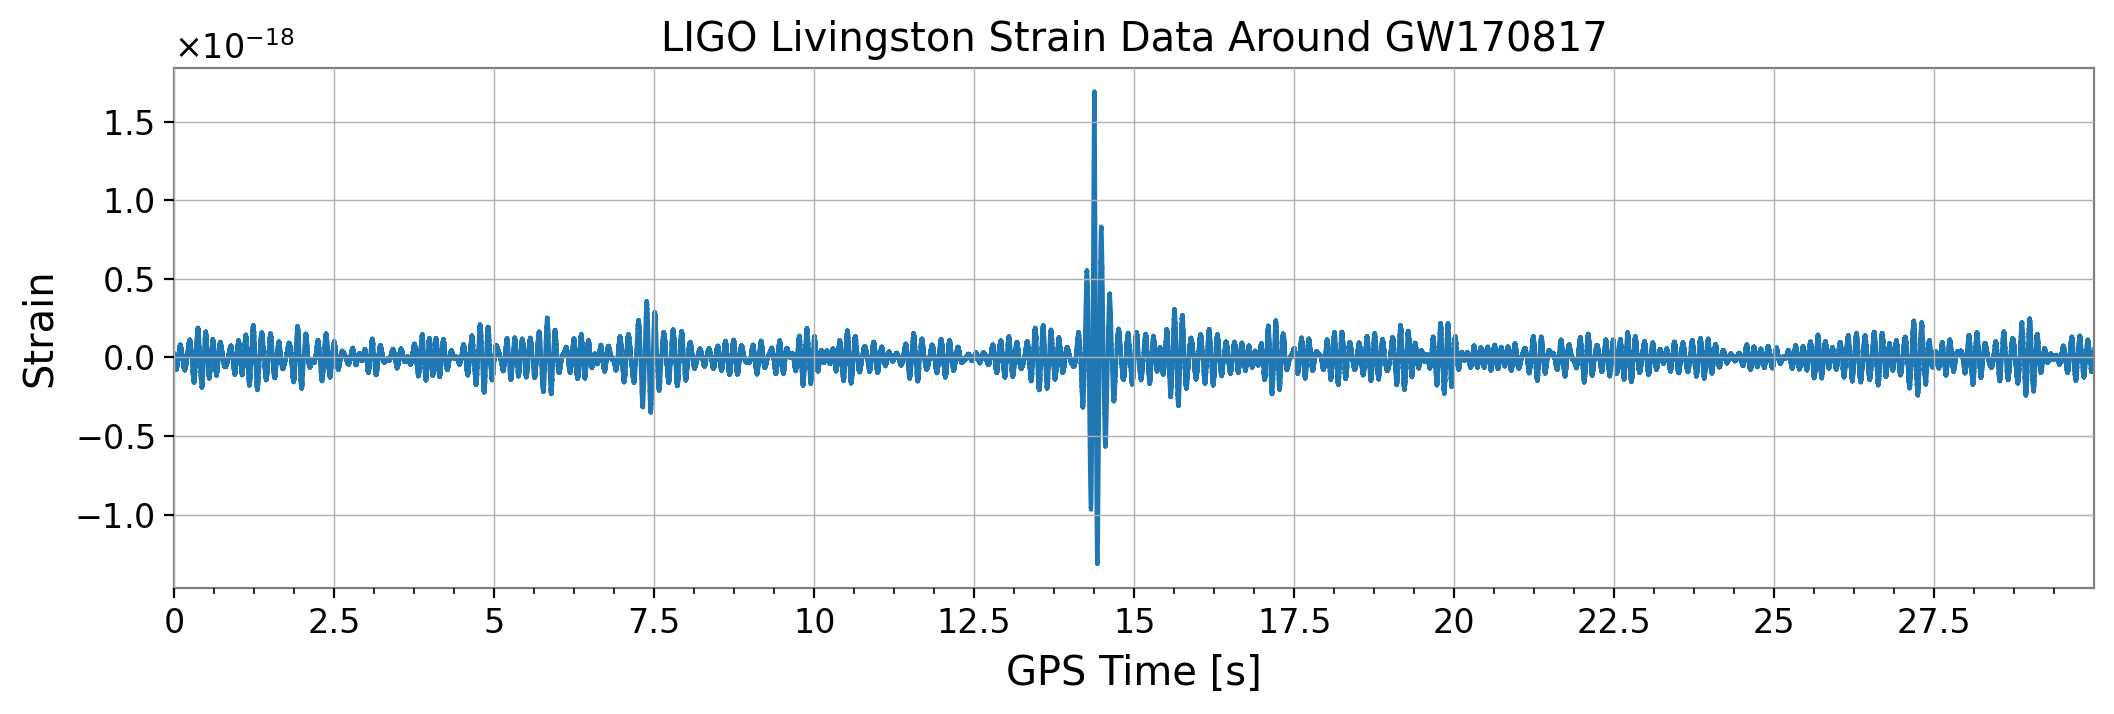

<Figure size 1000x500 with 0 Axes>

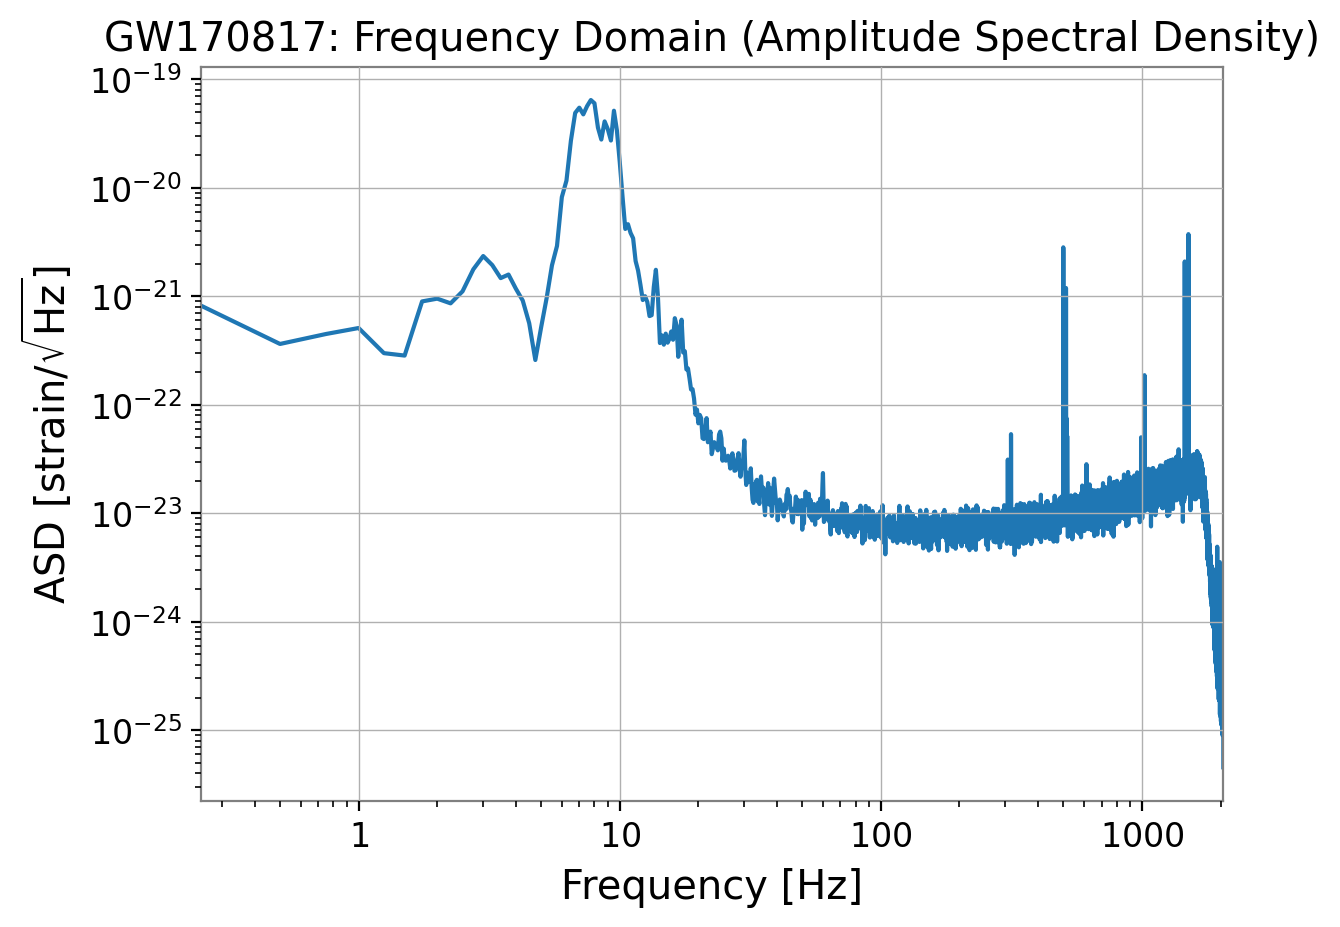

In [33]:
!pip install --quiet "gwpy==3.0.8" "astropy==5.3.4" matplotlib==3.7.3 gwosc

# Import the function that retrieves the GPS timestamp of a specific gravitational wave event
from gwosc.datasets import event_gps

# Import TimeSeries from GWPy to fetch and manipulate gravitational wave strain data
from gwpy.timeseries import TimeSeries

#### Plot from Notebook 2 is posted here:

# Enable inline plotting so that graphs display directly below each code cell
%matplotlib inline

# Get the GPS time (in seconds) of the GW170817 event (a neutron star merger)
gps_time = event_gps("GW170817")

# Define the time window: 15 seconds before and 15 seconds after the event
start = int(gps_time) - 15
end = int(gps_time) + 15

# Fetch the open strain data from the LIGO Livingston detector (L1) during the defined time window
# 'verbose=True' allows us to see download status and diagnostic output
hdata = TimeSeries.fetch_open_data("L1", start, end, verbose=True)

# Plot the strain data as a function of time
hdata.plot()

# Add a title to the time-domain plot
plt.title("LIGO Livingston Strain Data Around GW170817")

# Label the x-axis as GPS time (in seconds)
plt.xlabel("GPS Time [s]")

# Label the y-axis as strain (dimensionless quantity)
plt.ylabel("Strain")

# Add a grid to the plot to make it easier to read
plt.grid(True)

# Display the time-domain plot
plt.show()

# Compute the Amplitude Spectral Density (ASD) from the strain data
# This shows the signal strength as a function of frequency
asd = hdata.asd(fftlength=4)  # Use a 4-second FFT length to average over the data

# Create a new figure for the frequency-domain (ASD) plot
plt.figure(figsize=(10, 5))

# Plot the ASD curve
asd.plot()

# Add a title to the ASD plot
plt.title("GW170817: Frequency Domain (Amplitude Spectral Density)")

# Label the x-axis as frequency in hertz (Hz)
plt.xlabel("Frequency [Hz]")

# Label the y-axis as ASD in strain per root hertz
plt.ylabel(r"ASD [strain/$\sqrt{\mathrm{Hz}}$]")

# Add a grid to help interpret the frequency plot
plt.grid(True)

# Adjust layout to ensure labels and title fit cleanly
plt.tight_layout()

# Display the frequency-domain plot
plt.show()

When a gravitational wave passes through Earth, it stretches and squeezes space. The shape of this wave—how it rises and falls—is different depending on:
- How heavy the black holes are
- How fast they’re spinning
- How far away they are

That changing signal is like the leash in our pet example. It’s the evidence we use to learn more about the source.

## Quiz: Can you point out the chirp signal? What happens to the frequency and amplitude over time?

Let's zoom in on the merger time.

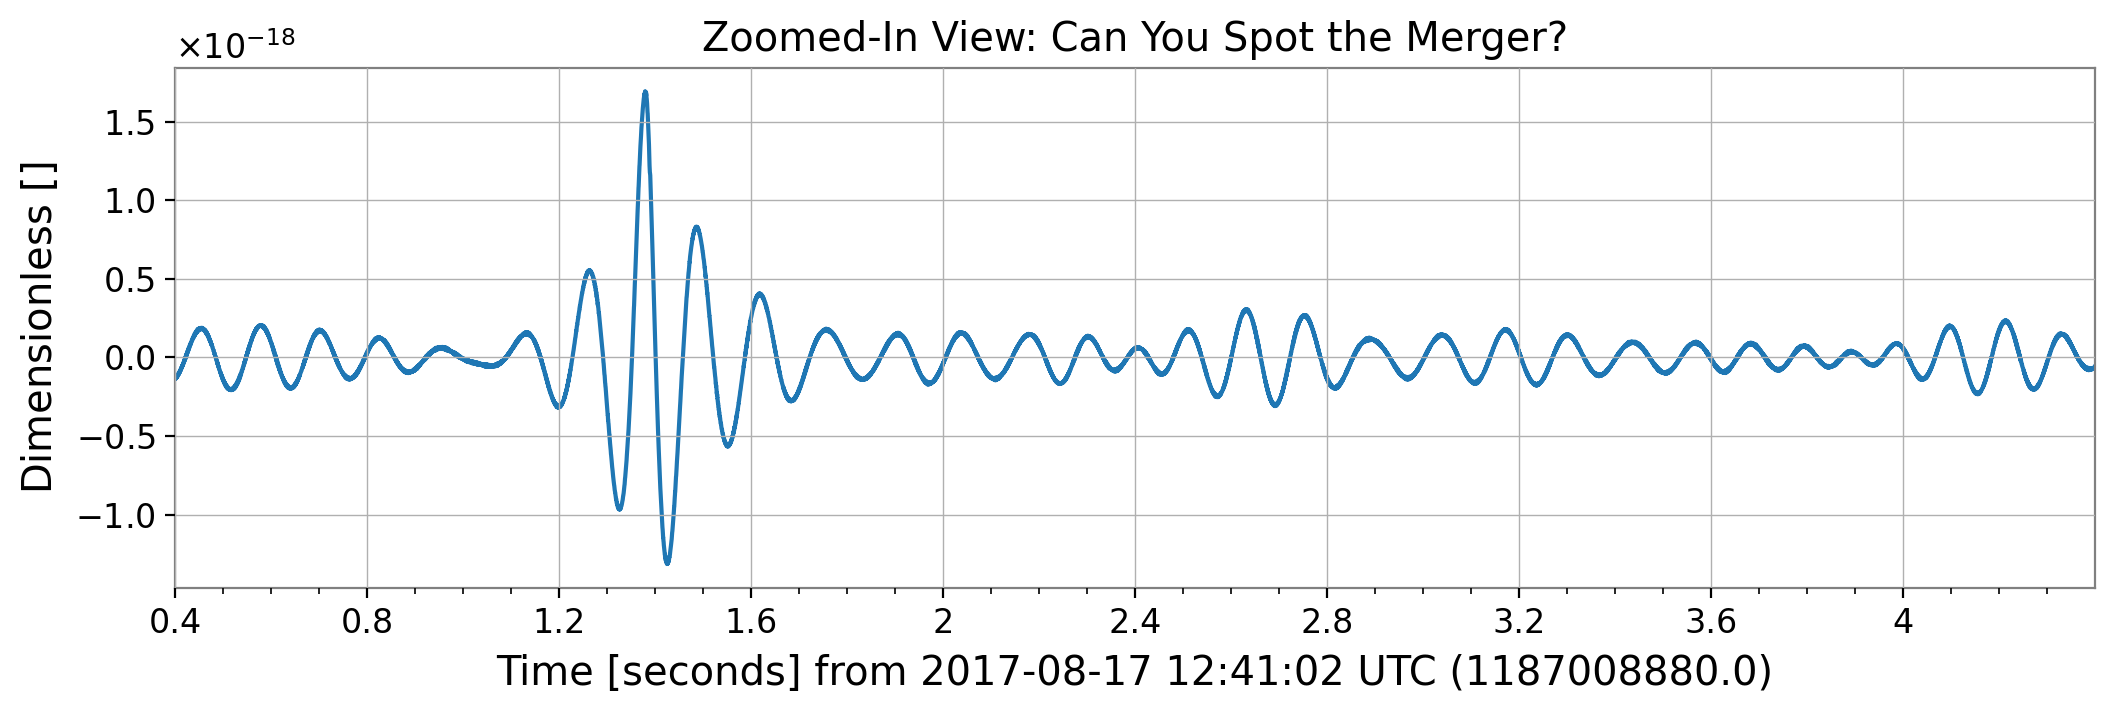

In [5]:
# Crop the data to a smaller 4-second window centered on the event
zoom = hdata.crop(gps_time - 2, gps_time + 2)

# Plot the zoomed-in data with a custom title
zoom.plot(title="Zoomed-In View: Can You Spot the Merger?")
plt.show()  # Display the plot

## Now let's play a parameter estimation game.

- Generate a few template waveforms for different chirp masses using a simple library like PyCBC
- Overplot each on the real data
- "Guess" which mass fits best!


In [6]:
# Define a function to generate a gravitational waveform template
def generate_template(m1, m2):
    # Compute the time-domain waveform using the TaylorT4 approximant
    hp, _ = get_td_waveform(approximant="TaylorT4",
                            mass1=m1, mass2=m2,
                            delta_t=1.0/4096,  # Sampling interval
                            f_lower=30)        # Starting frequency
    return hp  # Return the plus-polarization strain

In [34]:
def pad_or_trim_waveform(waveform, target_length):
    """
    Crop or pad waveform to match target_length.
    Pads with zeros if waveform is shorter than target_length.
    """
    # If the waveform is longer than the target length, crop it
    if len(waveform) > target_length:
        return waveform[:target_length]
    else:
        # If it's shorter, pad with zeros at the end to reach target length
        return np.pad(waveform, (0, target_length - len(waveform)), 'constant')

In [35]:
from ipywidgets import interact, FloatSlider

# Sampling settings
sampling_rate = 4096  # Hz sampling rate (number of samples per second)
duration = 2          # seconds to simulate
num_samples = int(sampling_rate * duration)  # total number of samples
times = np.linspace(0, duration, num_samples)  # array of time values for plotting

# True signal parameters
true_mass1 = 1.4  # mass 1 of the true (observed) system
true_mass2 = 1.4  # mass 2 of the true system
true_signal = generate_template(true_mass1, true_mass2)  # generate true waveform
true_signal = pad_or_trim_waveform(true_signal, num_samples)  # match target length

def interactive_guess_plot(guess_mass1=1.2, guess_mass2=1.2):
    """
    Plot the signals with adjustable guess parameters.
    """
    guess_signal = generate_template(guess_mass1, guess_mass2)  # generate guessed waveform
    guess_signal = pad_or_trim_waveform(guess_signal, num_samples)  # match target length

    # Plot the signals
    plt.figure(figsize=(10, 5))  # set figure size
    plt.plot(times, true_signal, label=f'Observed Signal ({true_mass1}+{true_mass2} $M_\\odot$)')  # plot true signal
    plt.plot(times, guess_signal, label=f'Guess: {guess_mass1:.2f}+{guess_mass2:.2f} M_sun', linestyle='--')  # plot guess
    plt.xlabel("Time (s)")  # x-axis label
    plt.ylabel("Strain")  # y-axis label
    plt.title("Compare Observed Signal to Your Guess")  # plot title
    plt.legend()  # add legend
    plt.grid(True)  # show grid
    plt.show()  # display the plot

# Create sliders without latex in description for compatibility
interact(
    interactive_guess_plot,
    guess_mass1=FloatSlider(value=1.2, min=0.5, max=3.0, step=0.01, description='Mass 1 (M_sun)'),
    guess_mass2=FloatSlider(value=1.2, min=0.5, max=3.0, step=0.01, description='Mass 2 (M_sun)')
)

interactive(children=(FloatSlider(value=1.2, description='Mass 1 (M_sun)', max=3.0, min=0.5, step=0.01), Float…

<function __main__.interactive_guess_plot(guess_mass1=1.2, guess_mass2=1.2)>

# We want to know: What is the most likely mass pair, given this data?

We use the same basic idea as before, but now the "thing we're guessing" is a black hole's mass, not a pet’s species.

**Bayes' Theorem** helps us calculate this. The formula is:

P(Mass | Signal) = (P(Signal | Mass) $\times$ $\frac{P(\text{Mass}))}{P(\text{Signal})}$

Let’s break it down:
- P(Mass | Signal): This is what we want to know. Given the gravitational-wave signal, what’s the chance the black hole had a certain mass?
- P(Signal | Mass): This is what we model. If the black hole had a certain mass, what kind of signal would we expect? Scientists use computer simulations for this.
- P(Mass): This is our prior belief—maybe based on what we know from past black holes. For example, we might believe black holes are usually between 5 and 50 times the mass of the Sun.
- P(Signal): This is the overall chance of getting a signal like the one we saw. It helps balance out the calculation.

Just like with pets, we update our beliefs when we get new evidence. A certain shape in the wave might make one black hole mass more likely than another.

In [11]:
def likelihood(real, template):
    # Computes a simple likelihood score based on mean squared error.
    # Lower difference between real and template => higher score.
    return 1 / np.mean((real - template) ** 2)

# Try three different mass guesses
mass_guesses = [(1.2, 1.2), (1.4, 1.4), (1.6, 1.6)]  # list of (mass1, mass2) pairs to test
scores = []  # store computed likelihood scores here

for m1, m2 in mass_guesses:
    temp = generate_template(m1, m2)  # generate waveform for this mass pair
    temp.resize(len(zoom))  # make sure it's the same length as the observed zoomed data
    score = likelihood(zoom.value, temp.numpy())  # compute likelihood
    scores.append(score)  # save the score

# Print results for each mass guess
for (m1, m2), s in zip(mass_guesses, scores):
    print(f"Mass guess {m1}+{m2} has likelihood score {s:.2e}")  # show score in scientific notation

Mass guess 1.2+1.2 has likelihood score 1.70e+37
Mass guess 1.4+1.4 has likelihood score 1.70e+37
Mass guess 1.6+1.6 has likelihood score 1.70e+37


Candidate Masses: [1.   1.02 1.04 1.06 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22
 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38 1.4  1.42 1.44 1.46
 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66 1.68 1.7
 1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18
 2.2  2.22 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42
 2.44 2.46 2.48 2.5  2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66
 2.68 2.7  2.72 2.74 2.76 2.78 2.8  2.82 2.84 2.86 2.88 2.9
 2.92 2.94 2.96 2.98 3.   3.02 3.04 3.06 3.08]


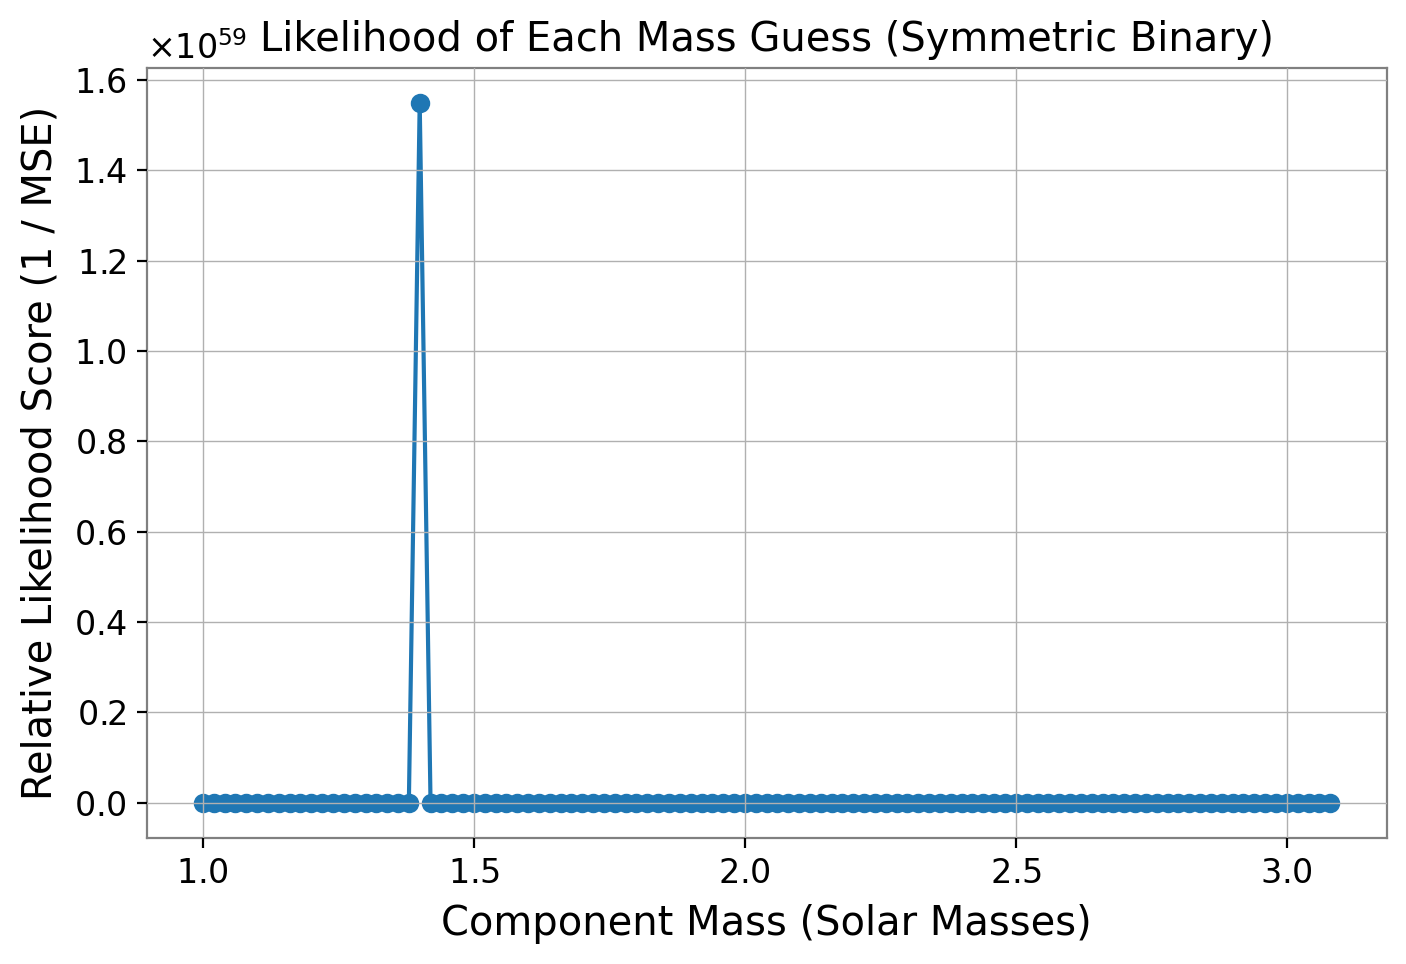

In [12]:
# Define candidate symmetric masses (m1 = m2)
candidate_masses = np.arange(1.0, 3.1, 0.02)  # Try masses from 1.0 to 3.0 in 0.02 steps
# Smaller step sizes give a smoother posterior curve
print("Candidate Masses:", candidate_masses)

scores = []  # List to hold likelihood scores for each mass guess

# Convert true signal to a NumPy array for easier math
true_array = np.array(true_signal)

# Loop through all candidate symmetric mass guesses
for mass in candidate_masses:
    # Generate template waveform for this symmetric mass pair
    signal = generate_template(mass, mass)
    # Make sure it's the same length as the observed signal
    signal = pad_or_trim_waveform(signal, num_samples)
    signal_array = np.array(signal)

    # Compute Mean Squared Error between candidate and true signal
    mse = np.mean((signal_array - true_array) ** 2)

    # Define a simple "likelihood" as inverse of MSE
    likelihood = 1 / mse if mse != 0 else np.inf
    scores.append(likelihood)

# Plot the likelihood scores as a function of mass
plt.figure(figsize=(8, 5))
plt.plot(candidate_masses, scores, marker='o')
plt.title("Likelihood of Each Mass Guess (Symmetric Binary)")
plt.xlabel("Component Mass (Solar Masses)")
plt.ylabel("Relative Likelihood Score (1 / MSE)")
plt.grid(True)
plt.show()

The point with the highest likelihood value is the component mass we believe the most. In this simple case, the recovered component masses are 1.4 M$_\odot$ which 100% aligns with our "true" values.

After a GW detection, scientists:
- Run simulations to see what kinds of waves different black hole systems would produce.
- Compare those simulated signals to the real one.
- Use Bayes’ Theorem to calculate which black hole properties best explain the data.

In more realistic cases, the result isn’t a single number—like “the black hole was 31 solar masses”—but a range of likely values, like:
“There’s an 80% chance the black hole was between 30 and 35 times the mass of the Sun.”


# Practice using Bayesian Parameter Estimation on a real GW Signal:

GWs us study things we can’t see with light. By using Bayesian probability, we can:
- Discover what kinds of black holes are out there
- Learn how they form and evolve
- Test Einstein’s theory of gravity

Let's now go through how to use [Bilby](https://bilby-dev.github.io/bilby/): a user-friendly Bayesian inference library for Gravitational-Wave data with GW170817.


## Getting the data: GW170817

We'll continue to analyse GW170817 in this notebook. Our first task is to obtain the data.

We need to know the trigger time. This can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW170817/), here we define it as a variable:

In [13]:
# Step 1: Get GPS time
# Look up the official GPS time of the GW170817 event using the GWOSC dataset
time_of_event = event_gps("GW170817")

> In this section of the code, we simulate the gravitational-wave signal produced by a binary neutron star system. The term “injection” refers to the intentional inclusion of a known, synthetic gravitational-wave signal — in this case, generated using known parameters (masses of 1.4 solar masses each). These known values represent the “true” parameters of a modeled astrophysical event, and are essential for validating our analysis methods. Starting with an injected signal allows us to test our waveform models and parameter estimation techniques in a controlled setting. By comparing this true signal to a “guess” waveform, students and researchers can visualize how sensitive gravitational-waveforms are to changes in parameters like mass, and begin to develop an intuition for the shape and structure of real signals in detector data. This approach mirrors the way scientists test detection pipelines before real data analysis, ensuring that our tools are accurate, reliable, and capable of uncovering the hidden properties of cosmic collisions.


In [14]:
# Step 2: We are going to inject a binary neutron star waveform.
# We first establish a dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two neutron stars (mass_1, mass_2),
# aligned spins of both neutron stars (chi_1, chi_2), etc.

# Define the injection parameters for the simulated gravitational wave signal
injection_parameters = dict(
    mass_1=1.5,              # Mass of neutron star 1 (solar masses)
    mass_2=1.3,              # Mass of neutron star 2 (solar masses)
    chi_1=0.02,              # Dimensionless spin of neutron star 1
    chi_2=0.02,              # Dimensionless spin of neutron star 2
    luminosity_distance=50.0, # Distance to the source in megaparsecs
    theta_jn=0.4,            # Angle between the total angular momentum and the line of sight
    psi=2.659,               # Polarization angle
    phase=1.3,               # Phase of the waveform at coalescence
    geocent_time=1126259642.413, # GPS time at the Earth's center
    ra=1.375,                # Right Ascension (radians)
    dec=-1.2108,             # Declination (radians)
    lambda_1=545,            # Tidal deformability parameter for neutron star 1
    lambda_2=1346,           # Tidal deformability parameter for neutron star 2
)

> To analyze the gravitational wave signal from GW170817 using the IMRPhenomPv2_NRTidal waveform model, we define a data segment with a duration of 32 seconds and a sampling frequency of 2048 Hz. This duration is chosen to be long enough to capture the full inspiral and merger phase of the binary neutron star event while keeping the data manageable. A high sampling frequency like 2048 Hz ensures that we can resolve the rapid oscillations of the waveform, especially near the merger. The start time is set a few seconds before the geocentric merger time, calculated as geocent_time + 2 - duration, so that the signal is positioned near the end of the segment. This placement allows for a clear view of the chirp and coalescence within a single window of data, which is essential for both visualization and injection into the detector strain data.


In [ ]:
# Step 3: Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the IMRPhenomPv2_NRTidal model:

duration = 32                  # Length of the data segment in seconds
sampling_frequency = 2048      # Samples per second (Hz)
start_time = injection_parameters["geocent_time"] + 2 - duration
# Compute the GPS start time so that the signal is centered near the end of the segment

> Step 4: Define waveform arguments using the IMRPhenomPv2_NRTidal model
The ‘IMRPhenomPv2_NRTidal’ waveform model is tailored specifically for binary neutron star (BNS) mergers. It extends the standard binary black hole waveform (IMRPhenomPv2) by incorporating tidal deformability effects derived from numerical relativity simulations. These tidal interactions arise because neutron stars, unlike black holes, have internal structure that distorts under intense gravitational forces during inspiral. This deformation produces subtle yet measurable changes in the gravitational wave signal, offering critical insights into the neutron star equation of state (EoS) — essentially, how matter behaves at nuclear densities.

For a comprehensive explanation of this model, see:
Dietrich et al. (2019) – “Improving the NRTidal model for binary neutron star systems”
https://arxiv.org/abs/1804.02235

In [ ]:
# Step 4
waveform_arguments = dict(
    # Specifies the waveform model tailored for binary neutron star mergers,
    # incorporating tidal effects from numerical relativity (NR) simulations
    waveform_approximant="IMRPhenomPv2_NRTidal",

    # Reference frequency (Hz) at which the binary parameters are defined
    reference_frequency=50.0,

    # Minimum frequency (Hz) to include in the waveform, matching detector sensitivity
    minimum_frequency=40.0,
)

> Step 5: Create the waveform generator using Bilby’s LAL-based source model
Bilby’s WaveformGenerator is a versatile interface that produces gravitational waveforms in the frequency domain. It integrates user-supplied source parameters with sophisticated waveform approximants from the LALSuite library, enabling realistic simulation of detector strain data.
In this example, the generator is configured for binary neutron star mergers. Key settings include:

	•	duration and sampling_frequency which define the time span and resolution of the generated signal,
	•	frequency_domain_source_model which selects the appropriate LAL function for BNS waveforms,
	•	parameter_conversion that translates astrophysical parameters into the LALSuite-compatible format,
	•	and waveform_arguments that fix waveform-specific parameters such as minimum frequency and waveform model choice.
  
This setup facilitates accurate and flexible modeling of BNS gravitational wave signals, foundational for parameter estimation and injection studies.

In [ ]:
# Step 5
# Create the waveform generator object using Bilby’s interface with LALSuite models
waveform_generator = bilby.gw.WaveformGenerator(
    # Duration of the waveform signal segment in seconds
    duration=duration,

    # Sampling frequency in Hz, defining time resolution of the waveform
    sampling_frequency=sampling_frequency,

    # LALSuite function to generate frequency-domain binary neutron star waveforms
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,

    # Converts user astrophysical parameters into the format expected by LAL functions
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,

    # Fixed waveform model arguments specified above
    waveform_arguments=waveform_arguments,
)

20:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


> In this step 6, we set up a list of three gravitational-wave interferometers using Bilby’s InterferometerList class. These interferometers correspond to the major detectors currently operating or having operated in the global network: H1 is the LIGO detector located in Hanford, Washington; L1 is the LIGO detector in Livingston, Louisiana; and V1 represents the Virgo detector near Pisa, Italy. Each detector has its unique geographic location and sensitivity, which enables triangulation and improves source localization. By specifying these detectors in our list, we simulate data streams that realistically model the noise characteristics and response of each observatory at design sensitivity. Setting the minimum frequency to 40 Hz aligns with the typical lower bound of sensitivity for current detectors. The code then generates synthetic noise strain data consistent with each detector’s power spectral density and injects the gravitational wave signal — modeled previously — into each detector’s strain data. This process allows us to simulate the multi-detector observation of an event like GW170817, providing a realistic dataset for subsequent analysis.


In [ ]:
# Step 6: Set up three interferometers: LIGO Hanford (H1), LIGO Livingston (L1), and Virgo (V1)
# These detectors simulate the gravitational wave data at their design sensitivity
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])

# Set the minimum frequency for each interferometer to 40 Hz (start of analysis range)
for interferometer in interferometers:
    interferometer.minimum_frequency = 40

# Generate synthetic strain data (noise) for each interferometer using power spectral densities
# sampling_frequency: how many samples per second
# duration: length of data segment in seconds
# start_time: GPS time marking the start of the segment
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)

# Inject the simulated gravitational wave signal into the strain data for all interferometers
# using the specified injection parameters and waveform generator
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

20:19 bilby INFO    : Injected signal in H1:
20:19 bilby INFO    :   optimal SNR = 34.44
20:19 bilby INFO    :   matched filter SNR = 34.48-1.44j
20:19 bilby INFO    :   mass_1 = 1.5
20:19 bilby INFO    :   mass_2 = 1.3
20:19 bilby INFO    :   chi_1 = 0.02
20:19 bilby INFO    :   chi_2 = 0.02
20:19 bilby INFO    :   luminosity_distance = 50.0
20:19 bilby INFO    :   theta_jn = 0.4
20:19 bilby INFO    :   psi = 2.659
20:19 bilby INFO    :   phase = 1.3
20:19 bilby INFO    :   geocent_time = 1126259642.413
20:19 bilby INFO    :   ra = 1.375
20:19 bilby INFO    :   dec = -1.2108
20:19 bilby INFO    :   lambda_1 = 545
20:19 bilby INFO    :   lambda_2 = 1346
20:19 bilby INFO    : Injected signal in L1:
20:19 bilby INFO    :   optimal SNR = 27.88
20:19 bilby INFO    :   matched filter SNR = 27.08-0.16j
20:19 bilby INFO    :   mass_1 = 1.5
20:19 bilby INFO    :   mass_2 = 1.3
20:19 bilby INFO    :   chi_1 = 0.02
20:19 bilby INFO    :   chi_2 = 0.02
20:19 bilby INFO    :   luminosity_distance 

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j,
         -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j,
         7.94402485e-26+4.21585695e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j,
         -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j,
         7.94402485e-26+4

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values. The first two we described in notebook two. The second two give the phase of the system and the time at which it mergers.

In [ ]:
# Step 7: Load the default prior distributions for binary neutron star (BNS) parameters
# Using chirp_mass, symmetric_mass_ratio, lambda_tilde, and delta_lambda_tilde
# instead of individual masses and tidal deformabilities for sampling

priors = bilby.gw.prior.BNSPriorDict()

# Set priors for extrinsic and spin parameters from the injection parameters
for key in [
    "psi",              # polarization angle
    "geocent_time",     # GPS time of event
    "ra",               # right ascension of source
    "dec",              # declination of source
    "chi_1",            # spin of first neutron star
    "chi_2",            # spin of second neutron star
    "theta_jn",         # angle between total angular momentum and line of sight
    "luminosity_distance", # distance to the source
    "phase",            # phase of the waveform at geocent_time
]:
    priors[key] = injection_parameters[key]  # Fix these parameters to injection values

# Remove priors on mass_ratio and individual tidal deformabilities since we sample
# in transformed parameters
del priors["mass_ratio"], priors["lambda_1"], priors["lambda_2"]

# Define prior on chirp_mass as a Gaussian centered at 1.215 solar masses with std 0.1
priors["chirp_mass"] = bilby.core.prior.Gaussian(
    1.215, 0.1, name="chirp_mass", unit="$M_{\odot}$"
)

# Define uniform prior on symmetric_mass_ratio between 0.1 and 0.25 (physically motivated range)
priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
    0.1, 0.25, name="symmetric_mass_ratio"
)

# Define uniform priors on combined tidal deformability parameters
priors["lambda_tilde"] = bilby.core.prior.Uniform(0, 5000, name="lambda_tilde")
priors["delta_lambda_tilde"] = bilby.core.prior.Uniform(
    -500, 1000, name="delta_lambda_tilde"
)

# Add constraints on individual tidal deformabilities (lambda_1, lambda_2) between 0 and 10000
priors["lambda_1"] = bilby.core.prior.Constraint(
    name="lambda_1", minimum=0, maximum=10000
)
priors["lambda_2"] = bilby.core.prior.Constraint(
    name="lambda_2", minimum=0, maximum=10000
)

20:19 bilby INFO    : No prior given, using default BNS priors in /usr/local/lib/python3.11/dist-packages/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


Bayesian inference is a powerful statistical framework used to estimate the probability distribution of unknown parameters based on observed data. The core idea involves updating prior beliefs about the parameters with new evidence from measurements, producing a **posterior probability distribution**. The **likelihood function** is a key component of Bayesian inference; it quantifies the probability of observing the data given a set of model parameters. Formally, the likelihood $\mathcal{L}$ is expressed as:

$\mathcal{L}(\text{data} \mid \theta) = p(\text{data} \mid \theta)$

where $\theta$ represents the parameters of the model. For gravitational wave data analysis, the likelihood models how probable the observed detector strain data is assuming a gravitational wave signal with parameters $\theta$ is present, combined with detector noise.

The `bilby.gw.GravitationalWaveTransient` likelihood object implements the standard transient gravitational wave likelihood, which assumes Gaussian, stationary noise and models the detector response to an injected waveform. It compares the expected signal (generated by the waveform model for given parameters) against the measured strain data across the interferometer network. This enables rigorous parameter estimation of astrophysical sources such as binary neutron star or black hole mergers.


In [ ]:
# Step 8: Initialize the likelihood object for gravitational wave analysis
# Pass in the interferometer data and the waveform generator to model the expected signals
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers,     # List of interferometers with strain data
    waveform_generator=waveform_generator,  # Waveform model generator for signal templates
)

> This step mounts your Google Drive storage within your Google Colab notebook environment, allowing you to easily read and write files just as if you were working locally on your computer. This is crucial when working with large datasets, saving results, or accessing pre-saved audio or data files during your gravitational wave analysis. The mount command only needs to be run once per Colab session to establish the connection.

In [16]:
# Step 9: This block helps us connect Google Colab to our Google Drive.
# That way, we can open files, save our work, and access folders—just like on your computer.

# This part is necessary when you're using files stored on your Drive (like data or sounds).
# Think of it like "plugging in" your Drive to Colab.

from google.colab import drive

# This line mounts (connects) your Google Drive to the notebook.
# You only need to run it ONCE per session. After that, your files will be available in the sidebar on the left.
drive.mount("/content/drive")  # Make sure this is only run once per session

Mounted at /content/drive


### Run the analysis! (estimated average runtime ~10 hours) Or read in the results file after the following cell.

In [ ]:
outdir = '/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result'  # Directory to save results
label = 'GW170817'         # Label for this analysis run

# Step 10: Run the sampler to perform Bayesian inference on the signal parameters
result = bilby.run_sampler(
    likelihood=likelihood,                  # Likelihood function defined earlier
    priors=priors,                         # Prior distributions on parameters
    sampler="dynesty",                     # Sampling algorithm (nested sampling)
    npoints=100,                           # Number of points to start with (may be ignored by dynesty)
    injection_parameters=injection_parameters,  # True signal parameters for reference
    outdir=outdir,                        # Output directory for results and plots
    label=label,                         # Label used in output files
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,  # Converts sampled params
    sample="unif",                       # Sampling method (uniform prior)
    nlive=500,                          # Number of live points controlling sampler accuracy
    dlogz=3                             # Stopping criterion for nested sampling evidence precision
)

01:35 bilby INFO    : Running for label 'GW170817', output will be saved to '/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result'
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
01:35 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundan

5791it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarni

02:21 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/166 [00:00<?, ?it/s]

02:21 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/166 [00:00<?, ?it/s]

02:21 bilby INFO    : Summary of results:
nsamples: 166
ln_noise_evidence: -96723.347
ln_evidence: -95330.403 +/-  0.720
ln_bayes_factor: 1392.944 +/-  0.720



### Looking at the result outputs:

To read in the result file successfully, you will need to **mount your own Google Drive** in your notebook environment. This allows the code to access files stored in your Google Drive.

After mounting, make sure to **update the file path** in the `read_in_result` function to match the exact location of your result file within your drive. The example path:

``` '/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result/GW170817_result.json' ```

Note: the space in "My Drive" is necessary.

In [17]:
# Read in the result file:
result = bilby.core.result.read_in_result('/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result/GW170817_result.json')

> When scientists analyze gravitational wave data, they want to figure out the most likely properties of the cosmic events—like the masses of the stars that collided. The posterior is like a treasure chest filled with many “best guesses” about these properties, each guess based on the data and what we already know. Imagine you’re trying to guess the weight of a mysterious box by shaking it and listening to clues. Instead of just one guess, you write down many possible weights that fit the clues well. The collection of all these guesses forms a distribution—the posterior—that tells you not only the most likely weight but also how confident you can be about it. So, the posterior shows the range and likelihood of parameters like the “chirp mass,” helping us understand what values fit the gravitational wave data best and how certain we are about those values.

In [18]:
# Access and display the posterior samples from the sampling run
result.posterior

,chirp_mass,symmetric_mass_ratio,lambda_tilde,delta_lambda_tilde,luminosity_distance,dec,ra,theta_jn,psi,phase,...,chi_eff,chi_1_in_plane,chi_2_in_plane,chi_p,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,1.215108,0.249024,865.918850,-250.929021,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.470026,1.297122,1.201647,2.767147
1,1.215007,0.248649,872.414577,287.592757,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.486483,1.282933,1.201547,2.769417
2,1.214970,0.248307,873.036670,320.563616,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.499860,1.271765,1.201511,2.771625
3,1.214996,0.248509,861.588596,359.306089,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.492124,1.278205,1.201536,2.770328
4,1.215090,0.248969,868.441681,160.270110,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.472594,1.294879,1.201629,2.767472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,1.215042,0.248757,866.272347,193.104121,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.481997,1.286780,1.201582,2.768777
162,1.215039,0.248727,866.059562,19.708211,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.483281,1.285692,1.201579,2.768973
163,1.215030,0.248666,867.089456,215.015070,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.485834,1.283526,1.201570,2.769360
164,1.215021,0.248658,865.858796,259.126076,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.486129,1.283261,1.201562,2.769390


In [19]:
# Extract and display the posterior distribution samples for the "chirp_mass" parameter
result.posterior["chirp_mass"]

,chirp_mass
0,1.215108
1,1.215007
2,1.214970
3,1.214996
4,1.215090
...,...
161,1.215042
162,1.215039
163,1.215030
164,1.215021


In [20]:
# Extract the numerical values of the chirp mass samples as a NumPy array
Mc = result.posterior["chirp_mass"].values

> The printed values below represent key statistics that summarize the range and most likely value of the chirp mass based on the posterior samples. The median is the middle value, meaning half the samples are below it and half are above—think of it as the “best estimate” or the most representative value of the chirp mass from the data.

> The 5% and 95% percentiles define the lower and upper bounds of a 90% confidence interval (C.I.). This interval tells us that there is a 90% probability that the true chirp mass lies somewhere between these two values. In other words, it captures the range within which we are highly confident the real value falls, based on the observed data and model. Reporting this interval conveys both the estimate and the uncertainty, which is crucial in scientific measurements where exact values are rarely known.

In [21]:
# Calculate the 5th percentile (lower bound) of the chirp mass samples
lower_bound = np.quantile(Mc, 0.05)

# Calculate the 95th percentile (upper bound) of the chirp mass samples
upper_bound = np.quantile(Mc, 0.95)

# Calculate the median (50th percentile) of the chirp mass samples
median = np.quantile(Mc, 0.5)

# Print the median and the 90% confidence interval (from 5% to 95%)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 1.215023337968737 with a 90% C.I = 1.2149831129629811 -> 1.215069415940215


### Now we can plot the 90% probability that the true chirp mass lies within this range based on the data and model assumptions:

> This histogram visually represents the posterior distribution of the chirp mass parameter based on the sampling results. Each bar shows how many samples fall into a given range, revealing where the chirp mass is most likely to lie. The taller bars indicate values with higher probability according to the data and the model.

> The shaded region highlights the 90% confidence interval, showing the range where we are most confident the true chirp mass exists, while the vertical line marks the median—the single best estimate. This visualization helps us see not just a single number, but the spread and uncertainty in our estimate.


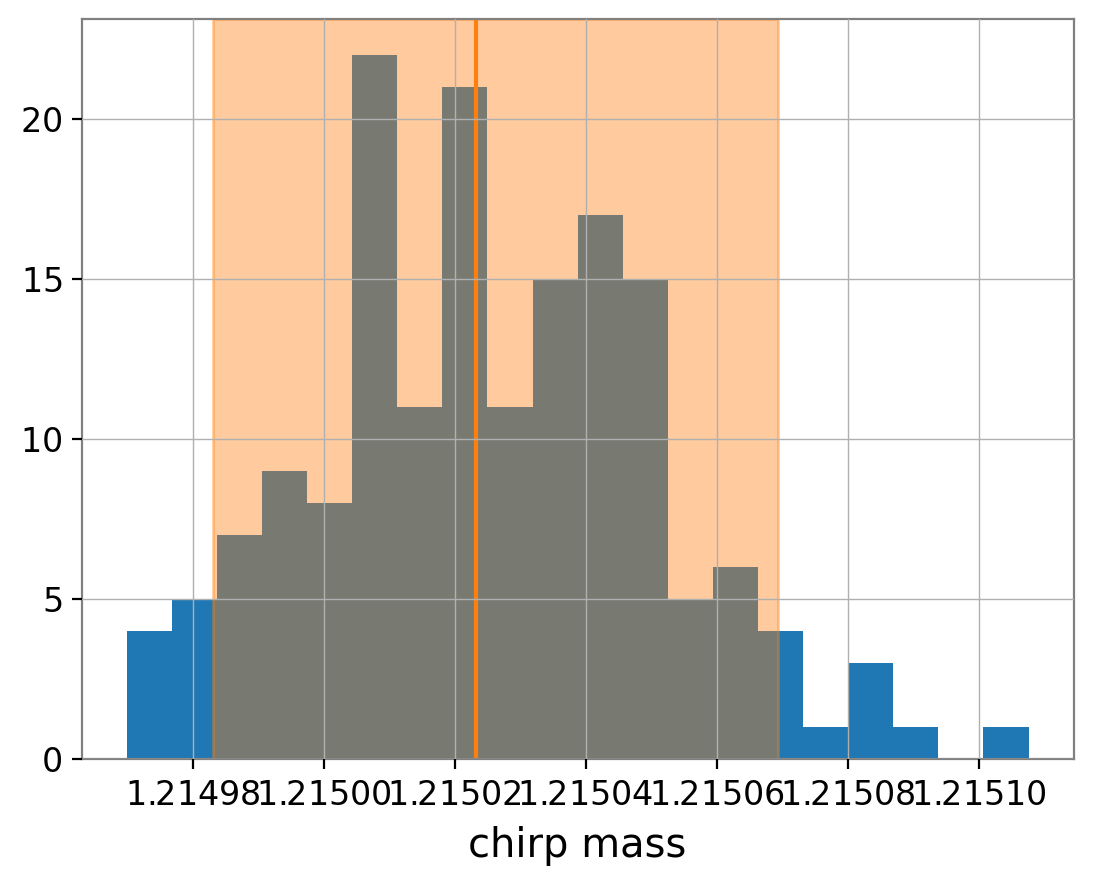

In [22]:
# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Plot a histogram of the posterior samples for chirp mass with 20 bins
ax.hist(result.posterior["chirp_mass"], bins=20)

# Highlight the 90% confidence interval region with a semi-transparent color
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)

# Draw a vertical line at the median chirp mass value
ax.axvline(median, color='C1')

# Label the x-axis
ax.set_xlabel("chirp mass")

# Display the plot
plt.show()

> Compared to the earlier chirp mass plot where we directly compared the observed and guessed waveforms, this histogram provides a statistical summary of the parameter estimation process. While the waveform plot gave a more physical and visual sense of how well a guess matches data, the histogram tells us the probability distribution over many possible chirp mass values. Together, these plots offer complementary views: one showing the waveform fitting in time, and the other showing the inferred parameter distribution from the Bayesian analysis.

### Corner Plot

The **corner plot** below shows the probability distributions of key parameters from the gravitational wave analysis—here, the *chirp mass* and *symmetric mass ratio*.

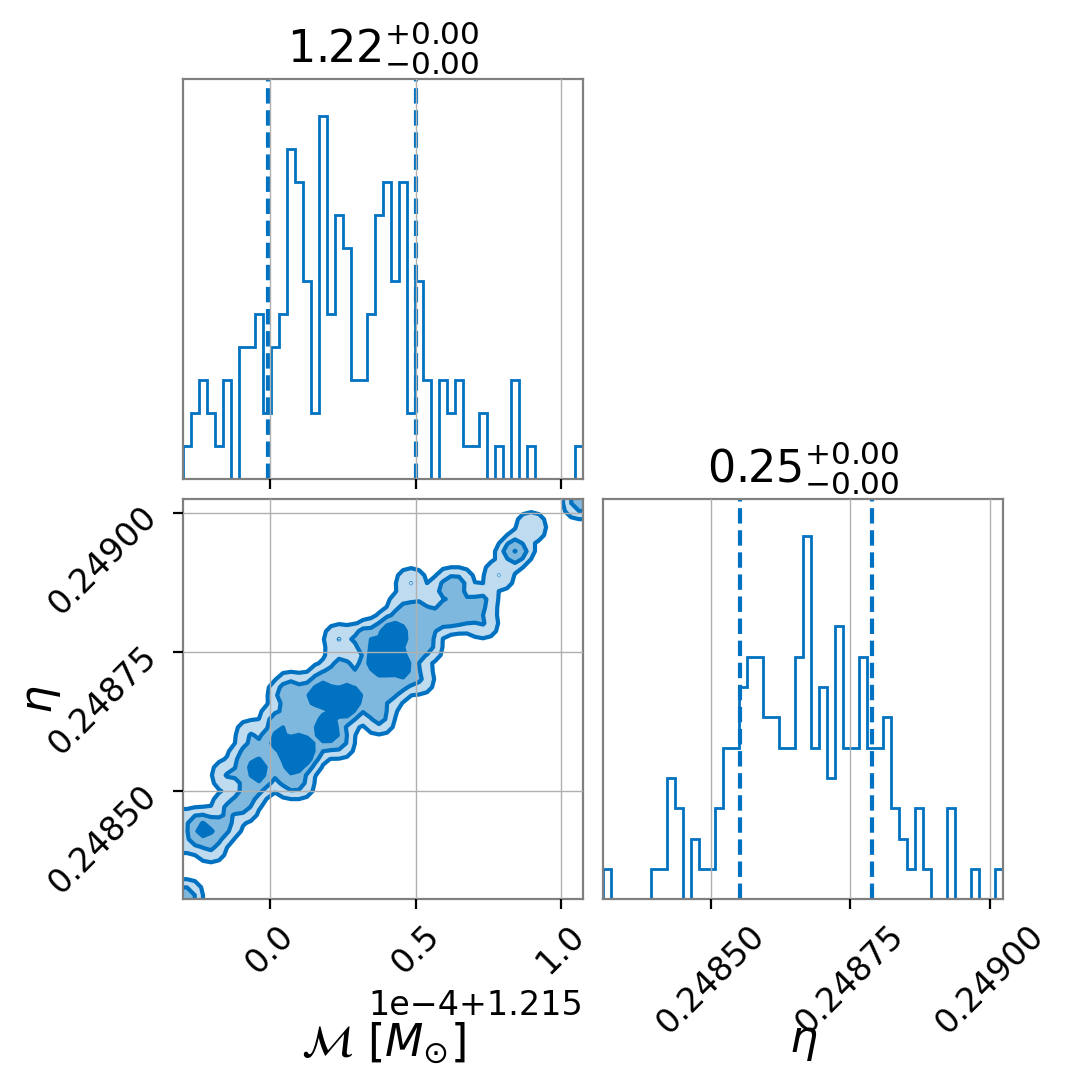

In [ ]:
# Plot a corner (pairwise joint distribution) plot of selected parameters
# Parameters plotted: chirp_mass, mass_ratio, geocent_time, and phase
# Include the prior distributions for comparison by setting prior=True
result.plot_corner(
    parameters=["chirp_mass", "symmetric_mass_ratio"],
    prior=True
)

- Along the diagonal, you see the **individual distributions** for each parameter. These tell you how likely different values are after analyzing the data.
- The plots off the diagonal show **joint distributions** of parameter pairs. These reveal how two parameters relate to each other—whether they are correlated or if certain combinations are more likely.

For example, the chirp mass and symmetric mass ratio often show a strong correlation, meaning knowing one helps predict the other.

The plot also includes the **prior distributions**—our initial beliefs before seeing the data—usually shaded or outlined. Comparing priors and posteriors shows how the data updated our understanding.

In summary, corner plots provide a detailed, visual way to see what values parameters most likely have and how they influence each other, which is essential for interpreting gravitational wave measurements.

### Calculate the Log Bayes Factor

The **log Bayes factor** is a number that tells us how much the data supports the idea that there is a real gravitational wave signal compared to just random noise.

- If this number is big and positive, it means the data very likely has a real signal.
- If it's small or negative, the data might just be noise.

The **error** shows how sure we are about this number — a smaller error means we can trust it more.

In [ ]:
# Print the log Bayes factor and its uncertainty (error)
# The Bayes factor measures how strongly the data supports the model compared to noise
print("ln Bayes factor = {} +/- {}".format(
    result.log_bayes_factor, result.log_evidence_err))

ln Bayes factor = 1392.9441676153444 +/- 0.72034765115605


### Multiple Choice Question (MCQ):

What was one of the major scientific breakthroughs achieved from the gravitational wave event GW170817?

A. Discovery of a new class of black holes \
B. First detection of gravitational waves from a binary neutron star merger \
C. First observation of gravitational waves without any electromagnetic counterpart \
D. Detection of dark matter annihilation through gravitational waves \

<details>
<summary><strong>Show Answer and Explanation</strong></summary>

Correct Answer: B. First detection of gravitational waves from a binary neutron star merger

Explanation:
GW170817 marked the first time in history that gravitational waves and electromagnetic signals (like gamma rays and visible light) were observed from the same astrophysical event. This neutron star merger allowed scientists to confirm theories about the origin of heavy elements (like gold and platinum), better understand the speed of gravitational waves, and refine the Hubble constant using statistical methods like Bayes’ Theorem. This multi-messenger event was a massive leap forward for astrophysics.

</details>



## Interpreting the GW170817 Analysis and Bayes Factor

The analysis of GW170817 beautifully showcases how Bayes’ Theorem lets us combine prior knowledge with gravitational wave data to precisely estimate key properties of a distant cosmic event, like the masses, distance, and orientation of merging neutron stars. Bayesian inference transforms raw, noisy signals into meaningful measurements with quantified uncertainties, revealing both the most likely characteristics of the source and how confident we are in those estimates—an essential part of scientific discovery.

A crucial result from this analysis is the very large **log Bayes factor**, here approximately **1393 ± 0.7**. The Bayes factor measures how strongly the data supports the presence of a gravitational wave signal compared to just noise. Such a high value means the observed data overwhelmingly favors the signal model, confirming beyond doubt that a real astrophysical event was detected rather than random noise. This strong statistical evidence gives us confidence that the parameter estimates derived from the data truly describe a real cosmic merger.


# Want to dig deeper beyond a single event? Continue to learn about the entire population of Gravitational-Wave mergers observed throughout the Universe so far!

# GWTC-3.0 Confident Parameter Estimation Results


LIGO Scientific Collaboration, Virgo Collaboration, & KAGRA Collaboration. (2024). The population of merging compact binaries inferred using gravitational waves through GWTC-3 - Data release (Version v3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.11254021

> Since the first detection of gravitational waves, dozens of compact binary mergers—primarily binary black holes and neutron star systems—have been observed, revealing a rich population of these cosmic collisions. The latest [Gravitational-Wave Transient Catalog (GWTC-3)](https://arxiv.org/abs/2111.03606), released by the LIGO, Virgo, and KAGRA collaborations, compiles confident parameter estimates for over 90 events, offering detailed insights into the masses, spins, and merger rates of these sources. Analyses of this dataset show intriguing features in the mass distributions, such as distinct peaks and gaps, suggesting complex astrophysical formation channels beyond simple power-law models.

> For a deep dive into these findings, see the key papers by the collaborations, including [Abbott et al. (2021)](https://arxiv.org/abs/2010.14527) on **GWTC-2** and the updated results in [Abbott et al. (2023)](https://arxiv.org/abs/2111.03606) for **GWTC-3**, which provide the foundation for understanding the evolving population of gravitational wave sources.

### Let's remake some of the correlation figures!

In [1]:
# Import the normal distribution functions from scipy.stats for statistical modeling
from scipy.stats import norm
# Import basic statistics module for calculating measures like mean, median, etc.
import statistics
# Import curve fitting function to fit models to data
from scipy.optimize import curve_fit
# Import Kernel Density Estimation from sklearn for smooth probability density estimates
from sklearn.neighbors import KernelDensity

# Import astronomical coordinate and distance handling tools from Astropy
from astropy.coordinates import SkyCoord, Distance
# Import units module from Astropy to handle physical units (e.g., parsecs, solar masses)
from astropy import units as u
# Import the Planck15 cosmology model for distance and redshift calculations
from astropy.cosmology import Planck15

# Import matplotlib patches for adding custom legend elements or shapes to plots
import matplotlib.patches as mpatches
# Import pandas for data manipulation and analysis, especially CSV file reading
import pandas as pd

In [2]:
# Read the CSV file containing the GWTC-3 confident event catalog data into a pandas DataFrame
# Make sure to adjust the file path to where your 'GWTC-3-confident.csv' file is located

gwtc3 = pd.read_csv('/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/GWTC-3-confident.csv')

In [3]:
gwtc3.head()

,id,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,...,redshift_upper,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW191103_012549-v1,GW191103_012549,1,GWTC-3-confident,1.256780e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,11.8,-2.2,6.2,...,0.09,0.46000,NaN,NaN,0.94318,NaN,NaN,19.0,-1.7,3.8
1,GW191105_143521-v1,GW191105_143521,1,GWTC-3-confident,1.257000e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,10.7,-1.6,3.7,...,0.07,0.01200,NaN,NaN,0.99000,NaN,NaN,17.6,-1.2,2.1
2,GW191109_010717-v1,GW191109_010717,1,GWTC-3-confident,1.257297e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,65.0,-11.0,11.0,...,0.18,0.00018,NaN,NaN,0.99000,NaN,NaN,107.0,-15.0,18.0
3,GW191113_071753-v1,GW191113_071753,1,GWTC-3-confident,1.257665e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,29.0,-14.0,12.0,...,0.18,26.00000,NaN,NaN,0.68339,NaN,NaN,34.0,-10.0,11.0
4,GW191126_115259-v1,GW191126_115259,1,GWTC-3-confident,1.258804e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,12.1,-2.2,5.5,...,0.12,3.20000,NaN,NaN,0.70041,NaN,NaN,19.6,-2.0,3.5


In [4]:
# Column options (see explanation below):
print(gwtc3.keys())

Index(['id', 'commonName', 'version', 'catalog.shortName', 'GPS', 'reference',
       'jsonurl', 'mass_1_source', 'mass_1_source_lower',
       'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper',
       'luminosity_distance', 'luminosity_distance_lower',
       'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower',
       'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower',
       'total_mass_source_upper', 'chirp_mass_source',
       'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass',
       'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower',
       'redshift_upper', 'far', 'far_lower', 'far_upper', 'p_astro',
       'p_astro_lower', 'p_astro_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_upper'],
      dtype='object')


<details>
<summary><strong>Explanation of Each Parameter:</strong></summary>

	1.	id
→ The official name of the gravitational wave event.
Format: GW[YYMMDD]_[Time], e.g., GW191103_012549.

	2.	commonName
→ A shorter, more familiar name for the event, often just omitting the version suffix (e.g., -v1).

	3.	version
→ The version number of this event’s data. This shows whether it’s the first release (1) or a later update.

	4.	catalog.shortName
→ Identifies which catalog the event comes from. For example, GWTC-3-confident means it comes from the third Gravitational Wave Transient Catalog and is confidently classified.

	5.	GPS
→ The Global Positioning System time (in seconds since January 6, 1980) when the event occurred.

	6.	reference
→ A path pointing to the event’s data or associated paper within the GWOSC data structure.

	7.	jsonurl
→ A direct link to the JSON metadata file for the event, hosted on GWOSC, containing detailed parameters.

	8.	mass_1_source
→ The estimated source-frame mass (in solar masses) of the primary (more massive) compact object (e.g., black hole or neutron star) before merging.

	9.	mass_1_source_lower
→ The lower bound (uncertainty) on the primary mass.

	10.	mass_1_source_upper
→ The upper bound (uncertainty) on the primary mass.

⸻

Skipping repeated structure for brevity, but know that other parameters like mass_2_source, chirp_mass, luminosity_distance, etc., follow a similar naming pattern with _lower and _upper bounds for uncertainties.

⸻

	11.	redshift_upper
→ The upper uncertainty on the estimated redshift of the event (how much the signal is stretched due to cosmic expansion).

	12.	far
→ False Alarm Rate – how often a similar event could have occurred just from random detector noise. Lower is better (i.e., more confident detection).

	13.	far_lower / far_upper
→ Lower and upper estimates for the false alarm rate (sometimes NaN if not available).

	14.	p_astro
→ The astrophysical probability that this signal is from a true astrophysical source rather than noise. Values close to 1 mean high confidence.

	15.	p_astro_lower / p_astro_upper
→ The uncertainties associated with that astrophysical probability.

	16.	final_mass_source
→ Estimated mass of the final object formed after the merger (e.g., a black hole).

	17.	final_mass_source_lower
→ The lower uncertainty of that final mass.

	18.	final_mass_source_upper
→ The upper uncertainty of that final mass.


19. total_mass_source
→ Total mass of the system in the source frame.

  20. total_mass_source_lower / total_mass_source_upper
→ Uncertainty range for the total mass in the source frame.

21. chirp_mass_source
→ “Chirp mass” of the system, a key parameter affecting gravitational wave frequency evolution.

22. chirp_mass_source_lower / chirp_mass_source_upper
→ Uncertainty range for the chirp mass.

23. mass_ratio
→ Ratio of the lighter mass to the heavier mass in the binary (q = m2/m1, where m2 ≤ m1).

24. mass_ratio_lower / mass_ratio_upper
→ Uncertainty range for the mass ratio.

25. chi_eff
→ Effective spin aligned with the orbital angular momentum (influences inspiral rate).

26. chi_eff_lower / chi_eff_upper
→ Uncertainty range for the effective spin.

27. chi_p
→ Effective precession spin parameter (captures spin-induced orbital precession).

28. chi_p_lower / chi_p_upper
→ Uncertainty range for precession spin.

29. luminosity_distance
→ Distance to the gravitational wave source in megaparsecs (Mpc).

30. luminosity_distance_lower / luminosity_distance_upper
→ Uncertainty range for the luminosity distance.

31. redshift
→ Cosmological redshift caused by the expansion of the universe.

32. redshift_lower / redshift_upper
→ Uncertainty range for the redshift value.

33. cos_theta_jn
→ Cosine of the angle between the total angular momentum and the line of sight.

34. cos_theta_jn_lower / cos_theta_jn_upper
→ Uncertainty range for the orientation angle.

35. network_matched_filter_snr
→ Signal-to-noise ratio from matched filtering across the detector network.

36. network_optimal_snr
→ The optimal (maximum possible) SNR achievable given the data.

37. p_astro
→ Probability that the event is of astrophysical origin.

38. has_remnant_mass_gap
→ Indicates if the final object’s mass lies in the “mass gap” (between neutron stars and black holes).

39. has_mass_gap
→ Indicates if either component lies in the mass gap.

40. has_ns
→ True if at least one object is consistent with a neutron star.

41. has_remnant
→ True if the event likely resulted in a remnant object (like a black hole).

42. version
→ Data release version this event belongs to (e.g., O3b).

</details>


In [30]:
gwtc3['redshift'].max() # Maximum redshift (distance light has traveled) from the population

dist1 = Distance(unit=u.pc, z = gwtc3['redshift'].max(), cosmology = Planck15) # Turn this redshift into distance using astropy

print(dist1/1000000) # Distance / One Million to convert from Megaparsecs to parsecs

7128.328068765086 pc


In [31]:
print(max(gwtc3['mass_1_source'])) # Maximum primary source mass from the population in solar masses

87.0


In [29]:
print(np.std(gwtc3['mass_1_source'])) # Standard deviation of the primary source mass

17.921460399675656


Now that we’ve converted redshift into distance and explored some basic statistical parameters like the standard deviation of mass, we can start to examine how this population of black holes is distributed across different masses.

To get a clearer statistical view of the data, it’s helpful to begin with a simple histogram of the **primary source mass** $(m_1$).

A histogram groups the observed masses into bins and shows how frequently each mass range occurs in the population. This lets us quickly identify common mass scales, trends, and any peaks or gaps in the distribution.


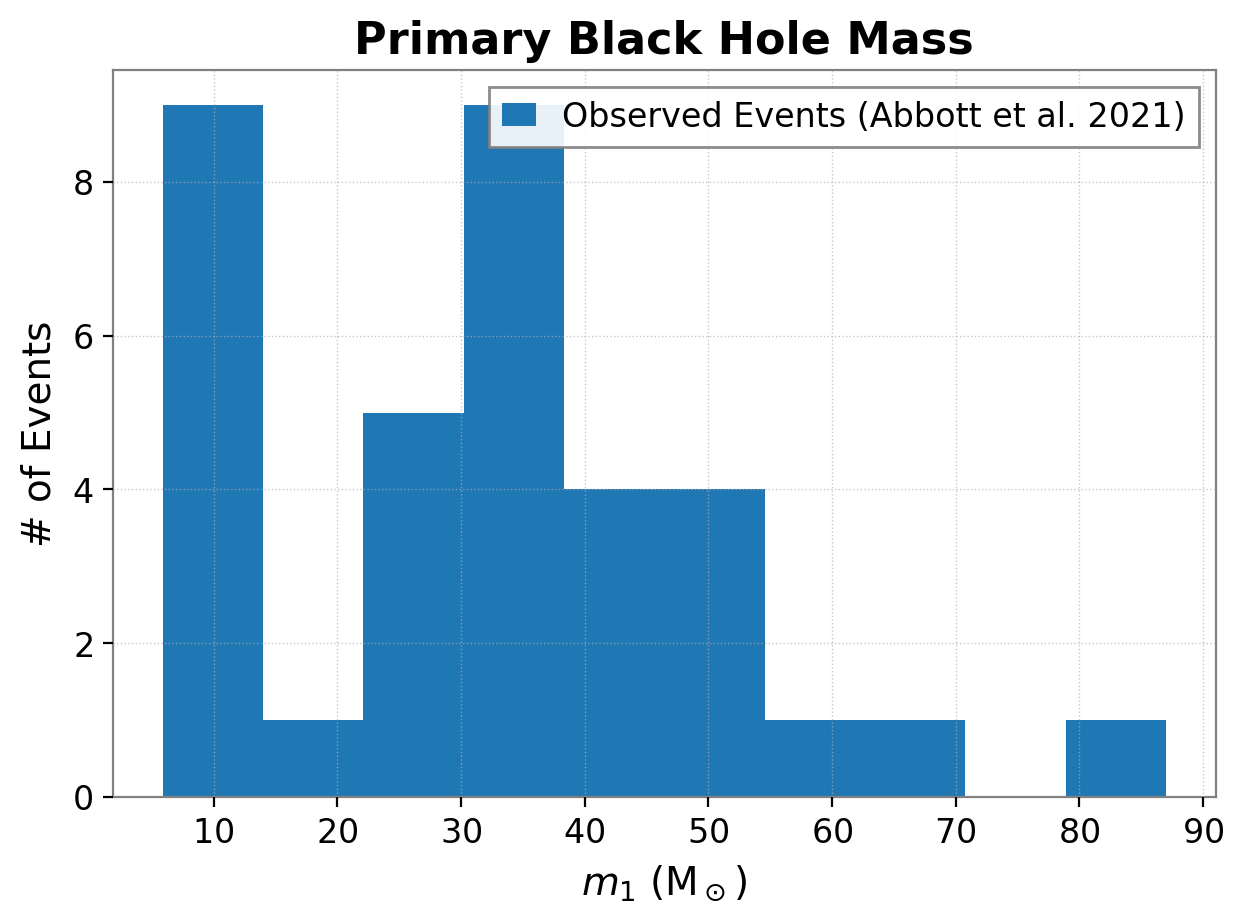

In [21]:
# Histogram plot of primary mass
plt.hist(gwtc3['mass_1_source'], label='Observed Events (Abbott et al. 2021)')

plt.xlabel(r'$m_1$ (M$_\odot$)', fontsize=14)
plt.ylabel(r'# of Events', fontsize=14)
plt.title('Primary Black Hole Mass', fontsize=16, fontweight='bold')

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=0.9, loc='upper right')

plt.tight_layout()
plt.show()

> By analyzing the histogram, we gain an intuitive sense of the population’s overall shape and where the majority of black hole masses lie, which sets the foundation for more detailed population studies like the evolution of primary mass with redshift.

Building on the histogram, we now want to understand how the rate of black hole mergers depends on the primary mass, not just in terms of raw counts, but normalized by the volume of the universe and the time over which these events occur.

This leads us to examine the **merger rate density** as a function of the primary mass $(m_1$), measured in units of:

- Number of mergers per cubic gigaparsec (Gpc$^3$) of cosmic volume,  
- Per year (time),  
- Per unit solar mass ($M_\odot$) of the primary black hole.

By studying the merger rate density, we get a physically meaningful picture of how common mergers of different masses are throughout the observable universe.

Fitting a **power law** to this distribution is important because many astrophysical processes naturally produce populations that follow power-law behaviors. This helps us quantify the underlying physics governing black hole formation and growth. Deviations from a simple power law—like peaks or cutoffs—can reveal new astrophysical phenomena or the influence of different formation channels.

In other words, the power-law fit provides a compact, interpretable model that captures the main trends in the data and serves as a baseline for testing more complex models of black hole populations.


/tmp/ipython-input-1204983188.py:7: RuntimeWarning: invalid value encountered in power
  return a * ((x - xmin) / (xmax - xmin))**alpha * np.exp(-smoothing * (x - xmin))
/tmp/ipython-input-1204983188.py:7: RuntimeWarning: invalid value encountered in scalar power
  return a * ((x - xmin) / (xmax - xmin))**alpha * np.exp(-smoothing * (x - xmin))


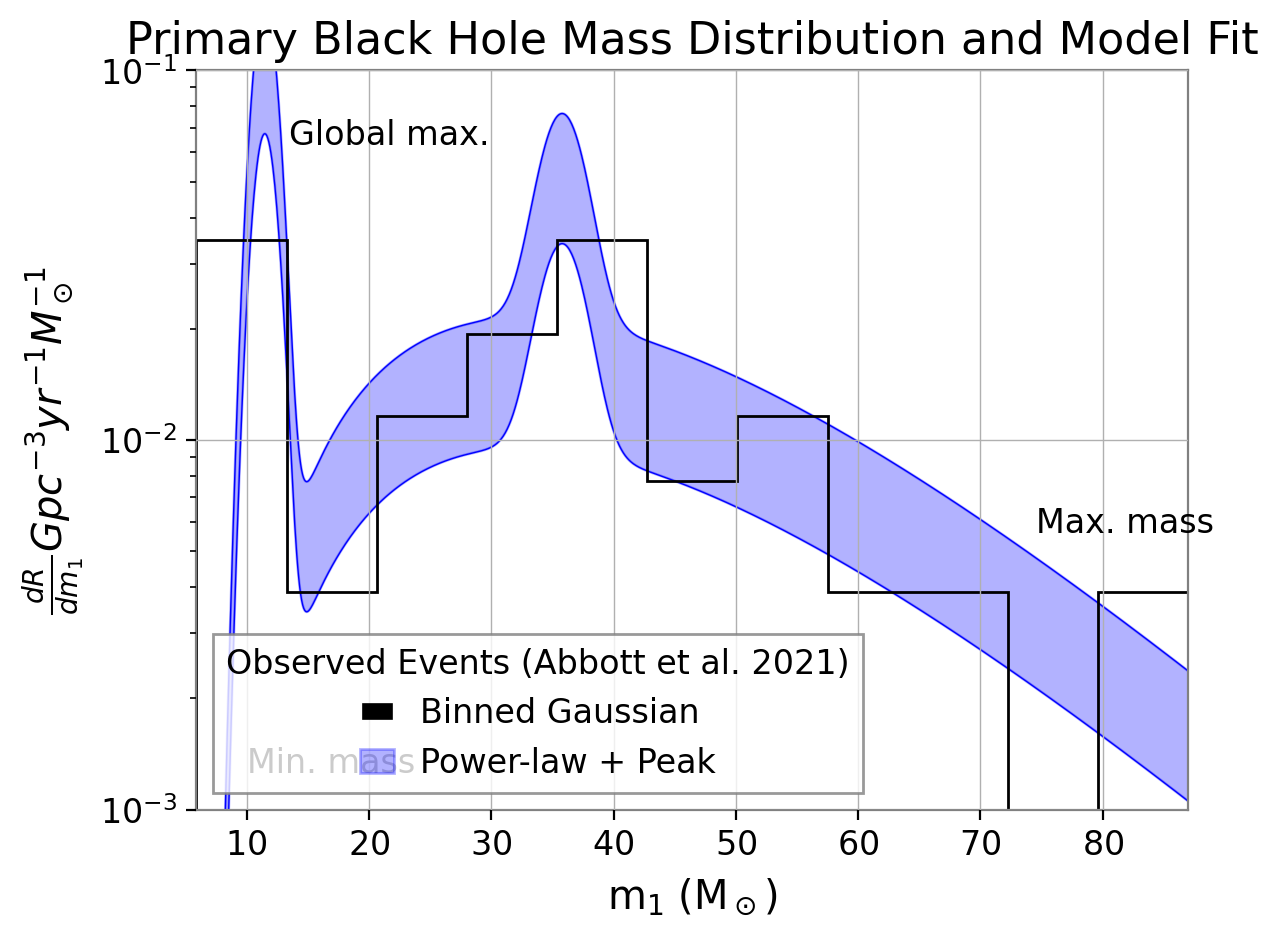

In [29]:
# Create a histogram to get the frequencies and bin edges
counts, bins = np.histogram(gwtc3['mass_1_source'], bins=30, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define the power law function
def power_law(x, alpha, a, xmin, xmax, smoothing):
    return a * ((x - xmin) / (xmax - xmin))**alpha * np.exp(-smoothing * (x - xmin))

# Define the Gaussian peak function
def gaussian_peak(x, a1, mu1, sigma1):
    return a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))

# Define the combined model: smoothed power law + double Gaussian peak
def combined_model(x, alpha, a, xmin, xmax, smoothing, a1, mu1, sigma1, a2, mu2, sigma2):
    return power_law(x, alpha, a, xmin, xmax, smoothing) + gaussian_peak(x, a1, mu1, sigma1) + gaussian_peak(x, a2, mu2, sigma2)

# Initial guess for the parameters (slope, amplitude, min mass, max mass, smoothing, Gaussian amplitude 1, Gaussian mean 1, Gaussian standard deviation 1, Gaussian amplitude 2, Gaussian mean 2, Gaussian standard deviation 2)
initial_guess = [1, 1, 5.9, 87.0, 0.1, 0.02, 8, 3, 0.03, 38, 5]

# Fit the combined model to the data
params, covariance = curve_fit(combined_model, bin_centers, counts, p0=initial_guess, maxfev = 150000)

# Generate points for the smoothed line representing the fit
x_fit = np.linspace(min(gwtc3['mass_1_source']), max(gwtc3['mass_1_source']), 1000)
y_fit = combined_model(x_fit, *params)

# Calculate the standard deviation at each point along the fitted curve
sigma_band = np.zeros_like(y_fit)
for i in range(len(x_fit)):
    sigma_band[i] = np.sqrt(np.sum((combined_model(x_fit[i], *params) - y_fit[i])**2))

# Plotting the shaded band
plt.plot(x_fit, 1.5*(y_fit + sigma_band), c='b', linewidth=0.5)
plt.plot(x_fit, (y_fit - sigma_band)/1.5, c='b', linewidth=0.5)
#plt.plot(x_fit, y_fit, c='b', linestyle='--', lw=1)
plt.fill_between(x_fit, (y_fit - sigma_band)/1.5, 1.5*(y_fit + sigma_band), edgecolor=(1,0,0,1), color='b', alpha = 0.3, linewidth=1)

plt.hist(gwtc3['mass_1_source'], bins=11, density=True, histtype=u'step', color='black')

# Adding labels, title, and legend
plt.xlabel('m$_1$ (M$_\odot$)')
plt.ylabel('$\\frac{dR}{dm_1} Gpc^{-3} yr^{-1} M^{-1}_\odot$')
plt.yscale('log')
plt.xlim(5.9,87.0)
plt.ylim(1e-3, 1e-1)
red_patch = mpatches.Patch(color='blue', label='Power-law + Peak', alpha=0.3)
black_line = plt.Line2D([0], [0], color='black', lw=1, label='Binned Gaussian')
plt.title('Primary Black Hole Mass Distribution and Model Fit', fontsize=16)
plt.legend()
plt.legend(handles=[black_line,red_patch], title='Observed Events (Abbott et al. 2021)')

#adding text inside the plot
plt.text(13.5, 10**-1.2, 'Global max.', fontsize = 12)
plt.text(10, 10**-2.9, 'Min. mass', fontsize = 12)
plt.text(74.5, 10**-2.25, 'Max. mass', fontsize = 12)


# Displaying the plot
# plt.savefig('./GWTC-3_MD.pdf', bbox_inches='tight')
plt.show()

> The primary source mass population plot above displays the distribution of black hole masses detected through gravitational wave observations. Each point represents an event, and the density of points reveals the most commonly observed mass ranges, typically clustering between 5 and 50 solar masses.

> The y-axis shows the **differential merger rate density with respect to the primary black hole mass**, denoted as

$
\frac{dR}{dm_1} \quad \left(\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1} \, M_\odot^{-1}\right)
$

This quantity represents the **expected number of binary black hole mergers per cubic gigaparsec (Gpc$^3$) of cosmic volume, per year, per unit solar mass** of the primary black hole mass ($m_1$).

- **Gpc($^{-3}$)**: Counts how many events occur in each cubic gigaparsec of the universe.  
- **yr($^{-1}$)**: Counts how many events occur each year.  
- **($M_\odot^{-1}$)**: Normalizes the rate per unit mass of the primary black hole, so it tells you how the merger rate changes as a function of the mass ($m_1$).

In other words, the y-axis tells us how frequently black holes of different masses merge throughout the universe, normalized per mass interval, volume, and time.

Since the scale is logarithmic, small y-values represent very rare events and large values represent more frequent mergers at that mass.

> This type of plot helps us understand the underlying astrophysical population and the processes leading to black hole formation. Additionally, by exploring correlations between parameters—such as mass versus redshift, or mass ratio versus spin—we can infer evolutionary trends, selection effects, and the influence of formation channels. Let's take a quick look at some more known population correlations.


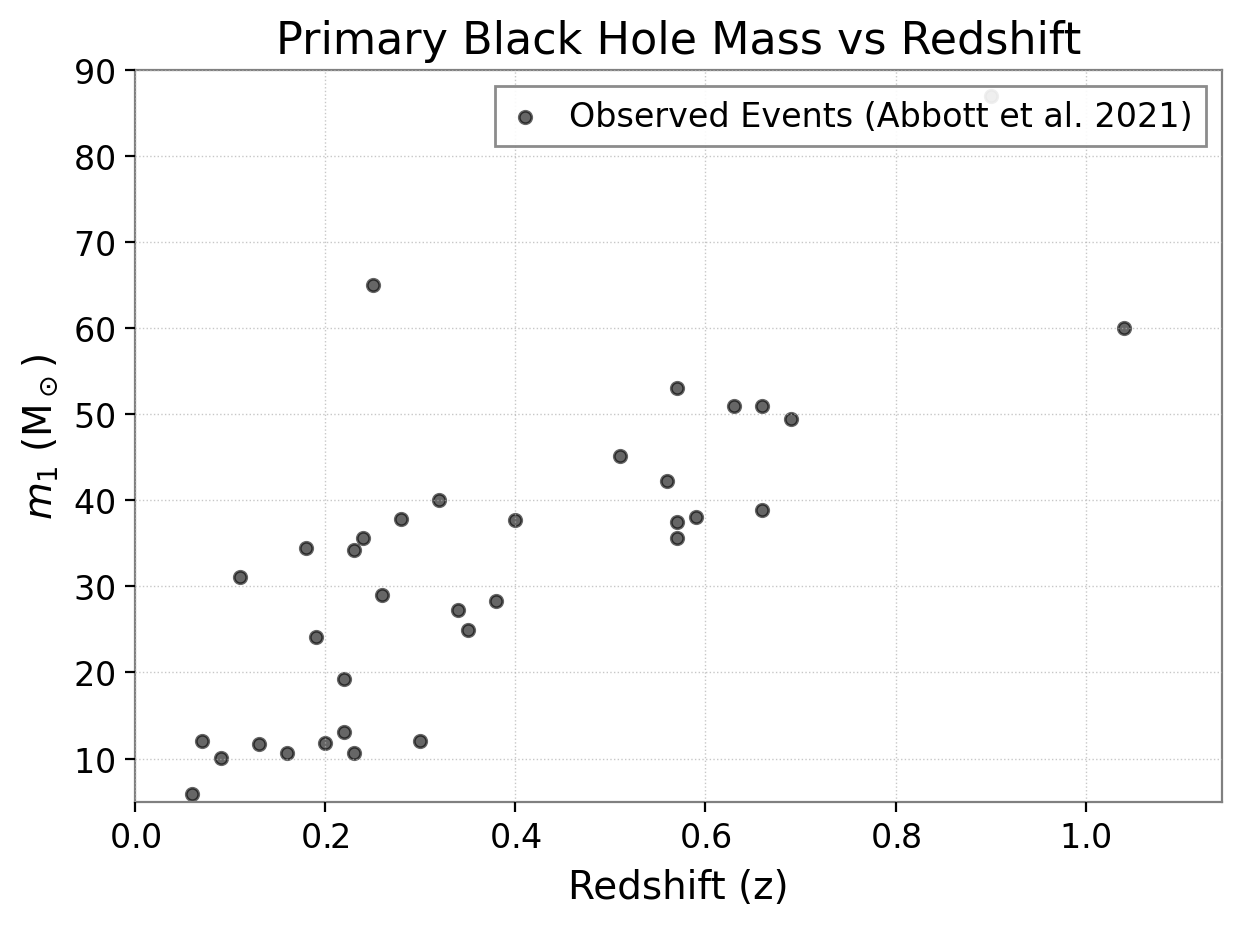

In [26]:
# Scatter plot of primary mass vs redshift
plt.scatter(gwtc3['redshift'], gwtc3['mass_1_source'], color='black', alpha=0.6, s=20, label='Observed Events (Abbott et al. 2021)')

# Add axis labels and title
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel(r'$m_1$ (M$_\odot$)', fontsize=14)
plt.title('Primary Black Hole Mass vs Redshift', fontsize=16)

# Set axis limits for better visualization
plt.xlim(0, max(gwtc3['redshift']) * 1.1)
plt.ylim(5, 90)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=0.9, loc='upper right')

plt.tight_layout()
plt.show()

This above scatter plot shows observed binary black hole mergers, with **primary mass ($m_1$)** on the vertical axis and **redshift (z)** on the horizontal axis.

- Each point represents an event from the GWTC-3 catalog.
- Higher masses tend to appear at larger redshifts because heavier black holes produce stronger signals that are easier to detect at greater distances.
- Lighter black holes are mostly observed nearby (low redshift) due to detection limits.
- This trend reflects observational bias rather than a direct physical correlation.

Understanding this helps correct biases and study black hole populations across cosmic history.


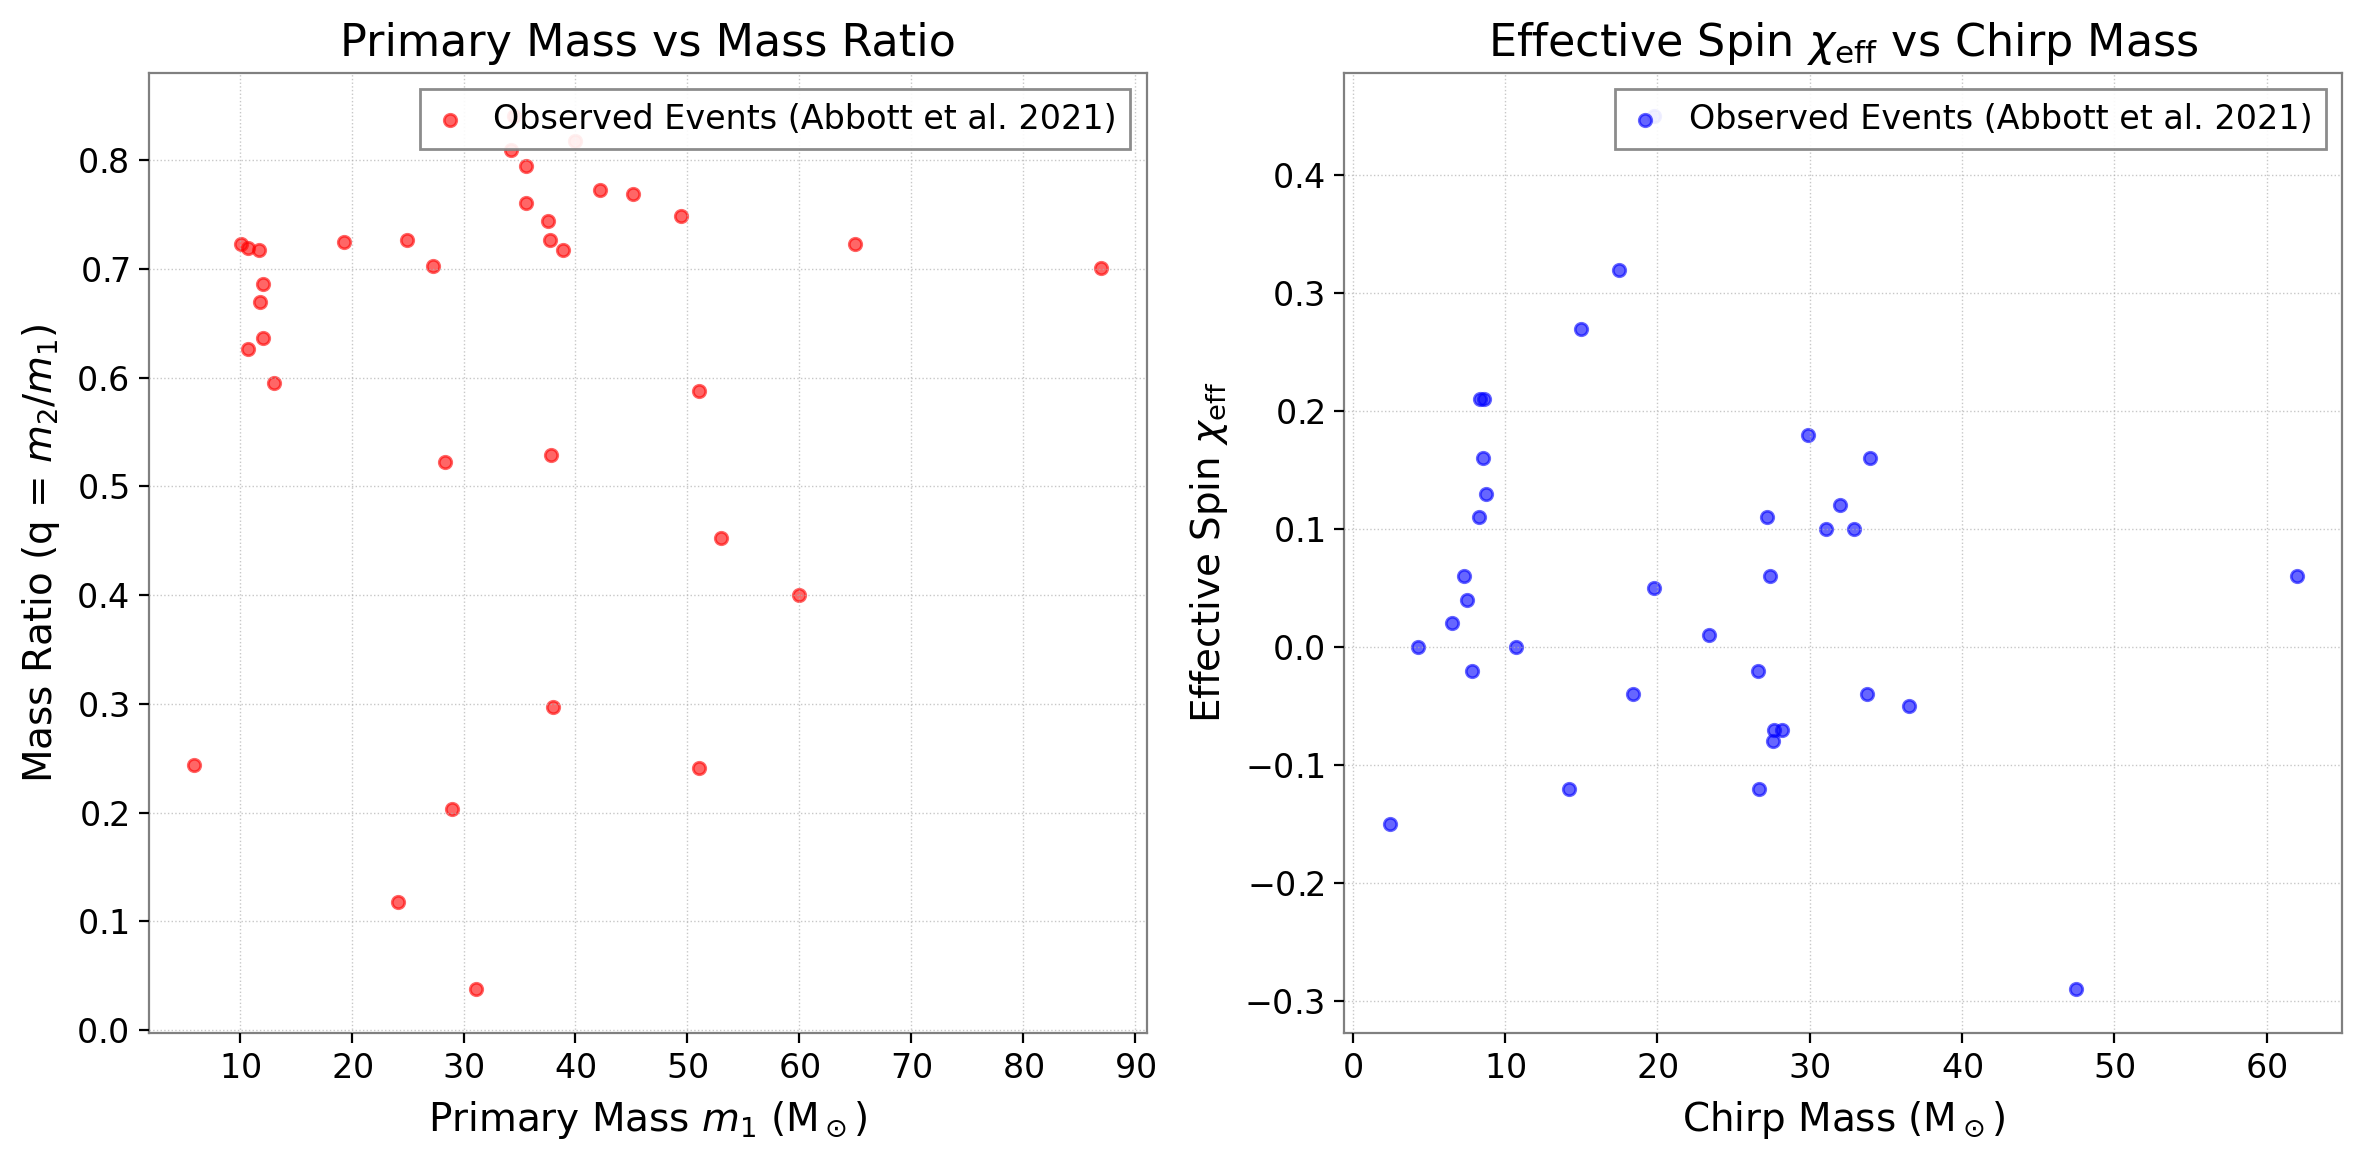

In [30]:
mass_ratio = gwtc3['mass_2_source'] / gwtc3['mass_1_source']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: Primary Mass vs Mass Ratio
axs[0].scatter(gwtc3['mass_1_source'], mass_ratio, color='red', alpha=0.6, s=20, label='Observed Events (Abbott et al. 2021)')
axs[0].set_xlabel(r'Primary Mass $m_1$ (M$_\odot$)', fontsize=14)
axs[0].set_ylabel('Mass Ratio (q = $m_2 / m_1$)', fontsize=14)
axs[0].set_title('Primary Mass vs Mass Ratio', fontsize=16)
axs[0].grid(True, linestyle=':', alpha=0.7)
axs[0].legend(fontsize=12, framealpha=0.9, loc='upper right')

# Right subplot: Effective Spin (chi_eff) vs Chirp Mass
axs[1].scatter(gwtc3['chirp_mass_source'], gwtc3['chi_eff'], color='blue', alpha=0.6, s=20, label='Observed Events (Abbott et al. 2021)')
axs[1].set_xlabel(r'Chirp Mass (M$_\odot$)', fontsize=14)
axs[1].set_ylabel(r'Effective Spin $\chi_{\mathrm{eff}}$', fontsize=14)
axs[1].set_title(r'Effective Spin $\chi_{\mathrm{eff}}$ vs Chirp Mass', fontsize=16)
axs[1].grid(True, linestyle=':', alpha=0.7)
axs[1].legend(fontsize=12, framealpha=0.9, loc='upper right')

plt.tight_layout()
plt.show()


These two scatter plots show important relationships in observed binary black hole mergers from GWTC-3:

- **Primary mass vs mass ratio (left):**  
  Displays how the primary black hole mass $(m_1$) relates to the mass ratio($q = \frac{m_2}{m_1}$). Points near $(q=1$) indicate nearly equal-mass binaries, which are common in isolated binary evolution.

- **Effective spin vs chirp mass (right):**  
  Shows the effective spin $(\chi_{\mathrm{eff}})$ against chirp mass, illustrating spin alignment relative to the orbital plane. More massive binaries tend to have a wider spread in effective spin.

The correlation of high mass ratios with aligned spins supports the idea that equal-mass binaries often form through isolated evolution, while more varied spins and mass ratios suggest dynamical formation channels.


# You’ve Engaged with Real Science

Throughout this journey, you’ve explored some of the most fascinating aspects of our universe—space, time, and gravity—not just as abstract ideas, but as tangible phenomena that scientists study every day.

You’ve learned that gravity is more than just a force pulling objects together. It’s actually the shape and bending of spacetime itself. This understanding allows us to detect ripples in the fabric of the universe called gravitational waves.

These waves come from some of the most extreme and mysterious events in the cosmos: collisions between massive objects like black holes and neutron stars, which are invisible to ordinary telescopes. By detecting and analyzing these signals, we can "listen" to the universe in a completely new way.

But more than just understanding what gravitational waves are, you’ve learned how to *interpret* the data they carry. This skill is at the heart of modern astrophysics. The tools and methods you’ve worked with here are the same ones scientists use to make groundbreaking discoveries today.

With this foundation, you’re equipped to:  

- Dive into actual astrophysical data and explore recent gravitational-wave detections  
- Investigate how these cosmic events teach us about the universe’s most extreme objects  
- Build your own visualizations and models to better understand and communicate these discoveries  
- Inspire others by showing that science is a process of exploration and continuous learning, not just a set of facts  

> The universe sends messages through ripples in spacetime.  

> Now, you have the tools to decode those messages.

---

Thank you for taking the time to explore these concepts. Remember, science is a journey—one fueled by curiosity, critical thinking, and a willingness to question and discover. Keep asking questions, keep exploring, and never stop looking up.

---

## Want to Explore Further?

If you want to continue your journey, check out the full dataset of gravitational-wave detections at [GWOSC.org](https://www.gw-openscience.org). For those interested in digging deeper, tools like PyCBC and Bilby offer access to waveform modeling and advanced data analysis pipelines.

---